# IGF signaling pathway simulations

In [95]:
# Load packages
from MScausality.causal_model.LVM import LVM
from MScausality.simulation.simulation import simulate_data
import MScausality.data_analysis.normalization as norm
import MScausality.data_analysis.gene_set as gs

import pyro
import pandas as pd
import numpy as np
from sklearn import linear_model

import networkx as nx
import y0
from y0.algorithm.simplify_latent import simplify_latent_dag
from y0.algorithm.identify import Identification, identify
from y0.dsl import P, Variable

import pickle
import copy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Build network

In [96]:
def build_igf_network(cell_confounder):
    """
    Create IGF graph in networkx
    
    cell_confounder : bool
        Whether to add in cell type as a confounder
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("EGF", "SOS")
    graph.add_edge("EGF", "PI3K")
    graph.add_edge("IGF", "SOS")
    graph.add_edge("IGF", "PI3K")
    graph.add_edge("SOS", "Ras")
    graph.add_edge("Ras", "PI3K")
    graph.add_edge("Ras", "Raf")
    graph.add_edge("PI3K", "Akt")
    graph.add_edge("Akt", "Raf")
    graph.add_edge("Raf", "Mek")
    graph.add_edge("Mek", "Erk")
    
    if cell_confounder:
        graph.add_edge("cell_type", "Ras")
        graph.add_edge("cell_type", "Raf")
        graph.add_edge("cell_type", "Mek")
        graph.add_edge("cell_type", "Erk")
    
    return graph

def build_admg(graph, cell_confounder=False, cell_latent=False):
    ## Define obs vs latent nodes
    all_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk", "EGF", "IGF"]
    obs_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk"]
    latent_nodes = ["EGF", "IGF"]
    
    ## Add in cell_type if included
    if cell_confounder:
        all_nodes.append("cell_type")
        if cell_latent:
            latent_nodes.append("cell_type")
        else:
            obs_nodes.append("cell_type")
        
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    # simplified_graph = simplify_latent_dag(graph.copy(), "hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")
    
    return y0_graph

In [97]:
cell_type_graph = build_igf_network(cell_confounder=True)
bulk_graph = build_igf_network(cell_confounder=False)
y0_graph_bulk = build_admg(bulk_graph, cell_confounder=False)

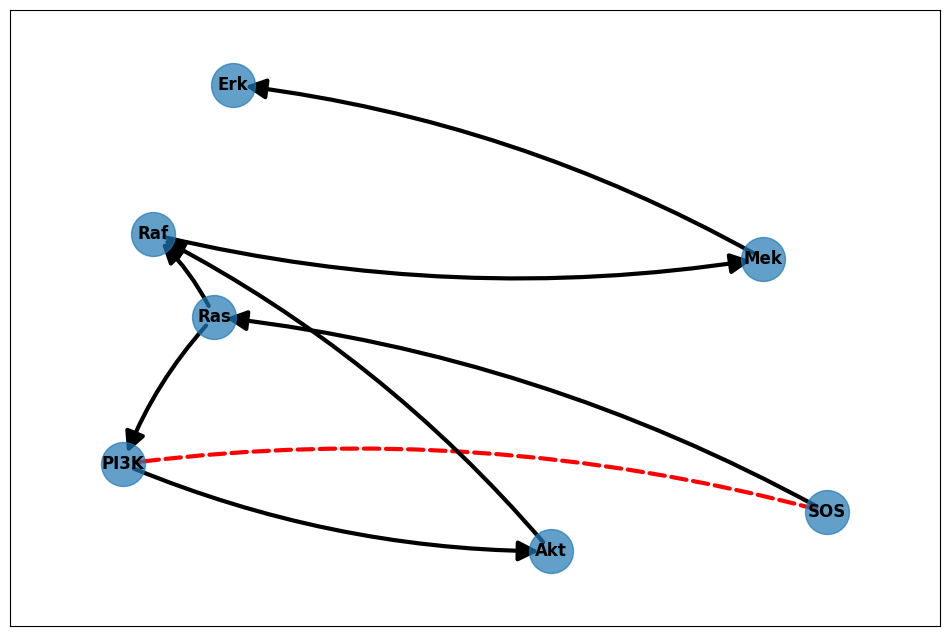

In [4]:
def plot_latent_graph(y0_graph, figure_size=(4, 3), title=None):

    ## Create new graph and specify color and shape of observed vs latent edges
    temp_g = nx.DiGraph()

    for d_edge in list(y0_graph.directed.edges):
        temp_g.add_edge(d_edge[0], d_edge[1], color="black", style='-', size=30)
    for u_edge in list(y0_graph.undirected.edges):
        if temp_g.has_edge(u_edge[0], u_edge[1]):
            temp_g.add_edge(u_edge[1], u_edge[0], color="red", style='--', size=1)
        else:
            temp_g.add_edge(u_edge[0], u_edge[1], color="red", style='--', size=1)

    ## Extract edge attributes
    pos = nx.random_layout(temp_g)
    edges = temp_g.edges()
    colors = [temp_g[u][v]['color'] for u, v in edges]
    styles = [temp_g[u][v]['style'] for u, v in edges]
    arrowsizes = [temp_g[u][v]['size'] for u, v in edges]

    ## Plot
    fig, ax = plt.subplots(figsize=figure_size)
    nx.draw_networkx_nodes(temp_g, pos=pos, node_size=1000, margins=[.1, .1], alpha=.7)
    nx.draw_networkx_labels(temp_g, pos=pos, font_weight='bold')
    nx.draw_networkx_edges(temp_g, pos=pos, ax=ax, connectionstyle='arc3, rad = 0.1',
                           edge_color=colors, width=3, style=styles, arrowsize=arrowsizes)
    if title is not None:
        ax.set_title(title)
    plt.show()
    
plot_latent_graph(y0_graph_bulk, figure_size=(12, 8))

## Ground truth invervention

Generate interventional data using the ground truth network for comparison.

In [72]:
## Coefficients for relations
cell_coef = {'EGF': {'intercept': 19., "error": 1, "cell_type" : [3, 0, -3]},
              'IGF': {'intercept': 17., "error": 1, "cell_type" : [3, 0, -3]},
              'SOS': {'intercept': -4, "error": .5, 
                      'EGF': 0.6, 'IGF': 0.6, "cell_type" : [3, 0, -3]},
              'Ras': {'intercept': 10, "error": .5, 'SOS': .5, "cell_type" : [3, 0, -3]},
              'PI3K': {'intercept': 1.6, "error": .5, 
                       'EGF': .5, 'IGF': 0.5, 'Ras': .5, "cell_type" : [3, 0, -3]},
              'Akt': {'intercept': 2., "error": .5, 'PI3K': 0.75, "cell_type" : [3, 0, -3]},
              'Raf': {'intercept': 10, "error": .5,
                      'Ras': 0.8, 'Akt': -.4, "cell_type" : [-2, 0, 2]},
              'Mek': {'intercept': 3., "error": .5, 'Raf': 0.75, "cell_type" : [-2, 0, 2]},
              'Erk': {'intercept': 4., "error": .5, 'Mek': 1.2, "cell_type" : [-2, 0, 2]}
             }

In [73]:
def obs_gt_sim(coef, n, cell_type, n_cells=1):
    
    """
    Observational ground truth simulation of network
    """
    
    if cell_type:
        cell_type = np.repeat([i for i in range(n_cells)], n//n_cells)
        if len(cell_type) < n:
            cell_type = np.append(cell_type, n_cells-1)
            
    EGF = np.random.normal(coef["EGF"]["intercept"], 3, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 3, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = coef["Ras"]["intercept"] + coef["Ras"]["SOS"]*SOS + np.array(coef["Ras"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.array(coef["Raf"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.array(coef["Mek"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Erk = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.array(coef["Erk"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    
    return({"EGF" : EGF, "IGF" : IGF, "SOS" : SOS, 
            "Ras" : Ras, "PI3K": PI3K, "Akt" : Akt,
            "Raf" : Raf, "Mek" : Mek, "Erk" : Erk, "cell_type" : cell_type})

def int_gt_sim(coef, n, inc_cell_type, n_cells=1):

    """
    Ras interventional simulation of network (Ras=10 vs Ras=20)
    """
    
    if inc_cell_type:
        cell_type = np.repeat([i for i in range(n_cells)], n//n_cells)
        if len(cell_type) < n:
            cell_type = np.append(cell_type, n_cells-1)
    else:
        cell_type = [1]
            
    EGF = np.random.normal(coef["EGF"]["intercept"], coef["EGF"]["error"], n)
    IGF = np.random.normal(coef["IGF"]["intercept"], coef["IGF"]["error"], n)

    SOS = sum([coef["SOS"]["intercept"], coef["SOS"]["EGF"]*EGF, 
               coef["SOS"]["IGF"]*IGF, np.random.normal(0, coef["SOS"]["error"], n)])
    Ras = 15
    PI3K = sum([coef["PI3K"]["intercept"], coef["PI3K"]["Ras"]*Ras, 
                coef["PI3K"]["EGF"]*EGF, coef["PI3K"]["IGF"]*IGF,
                np.random.normal(0, coef["PI3K"]["error"], n)])
    Akt = sum([coef["Akt"]["intercept"], coef["Akt"]["PI3K"]*PI3K,
                np.random.normal(0, coef["Akt"]["error"], n)])
    Raf = sum([coef["Raf"]["intercept"], coef["Raf"]["Ras"]*Ras, 
               coef["Raf"]["Akt"]*Akt, 
               np.array(coef["Raf"]["cell_type"])[cell_type],
                 np.random.normal(0, coef["Raf"]["error"], n)])
    Mek = sum([coef["Mek"]["intercept"], coef["Mek"]["Raf"]*Raf,
                np.array(coef["Mek"]["cell_type"])[cell_type],
                  np.random.normal(0, coef["Mek"]["error"], n)])
    Erk_obs = sum([coef["Erk"]["intercept"], coef["Erk"]["Mek"]*Mek, 
                 np.array(coef["Erk"]["cell_type"])[cell_type],
                   np.random.normal(0, coef["Erk"]["error"], n)])
    
    EGF = np.random.normal(coef["EGF"]["intercept"], coef["EGF"]["error"], n)
    IGF = np.random.normal(coef["IGF"]["intercept"], coef["IGF"]["error"], n)

    SOS = sum([coef["SOS"]["intercept"], coef["SOS"]["EGF"]*EGF, 
               coef["SOS"]["IGF"]*IGF, np.random.normal(0, coef["SOS"]["error"], n)])
    Ras = 20
    PI3K = sum([coef["PI3K"]["intercept"], coef["PI3K"]["Ras"]*Ras, 
                coef["PI3K"]["EGF"]*EGF, coef["PI3K"]["IGF"]*IGF,
                np.random.normal(0, coef["PI3K"]["error"], n)])
    Akt = sum([coef["Akt"]["intercept"], coef["Akt"]["PI3K"]*PI3K,
                np.random.normal(0, coef["Akt"]["error"], n)])
    Raf = sum([coef["Raf"]["intercept"], coef["Raf"]["Ras"]*Ras, 
               coef["Raf"]["Akt"]*Akt, 
               np.array(coef["Raf"]["cell_type"])[cell_type],
                 np.random.normal(0, coef["Raf"]["error"], n)])
    Mek = sum([coef["Mek"]["intercept"], coef["Mek"]["Raf"]*Raf,
                np.array(coef["Mek"]["cell_type"])[cell_type],
                  np.random.normal(0, coef["Mek"]["error"], n)])
    Erk_int = sum([coef["Erk"]["intercept"], coef["Erk"]["Mek"]*Mek, 
                 np.array(coef["Erk"]["cell_type"])[cell_type],
                   np.random.normal(0, coef["Erk"]["error"], n)])
    
    int_data = [Erk_obs, Erk_int]
    if inc_cell_type:
        int_data.append(cell_type)
        
    return int_data

gt_int_cell = int_gt_sim(cell_coef, 1000000, inc_cell_type=False, n_cells=1)

In [74]:
gt_int_cell

[array([18.80677802, 18.42474918, 19.3214154 , ..., 19.72309933,
        20.25347592, 19.63412168]),
 array([23.29831936, 24.74209882, 21.3059848 , ..., 23.596172  ,
        22.39324862, 22.32586024])]

Text(0.5, 1.0, 'Ground Truth Invervention')

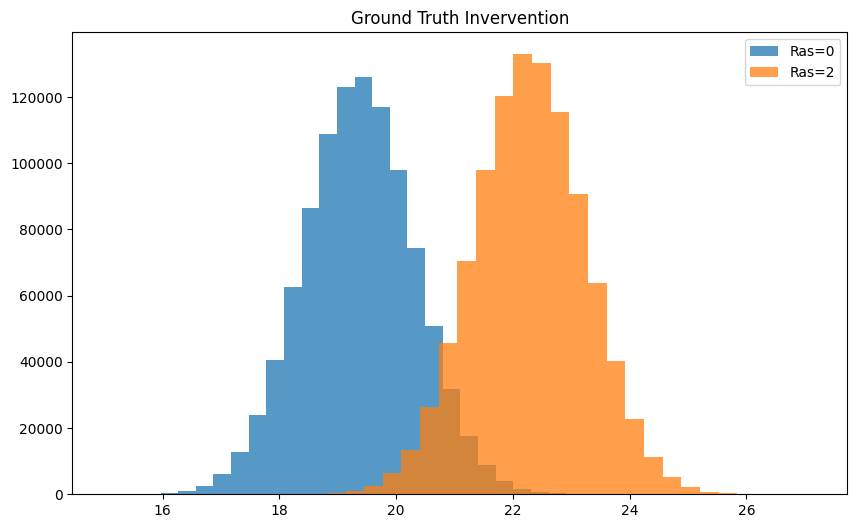

In [75]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(gt_int_cell[0], label="Ras=0", alpha=.75, bins=30)
ax.hist(gt_int_cell[1], label="Ras=2", alpha=.75, bins=30)
ax.legend()

# ax.hist(gt_int_cell[0][gt_int_cell[2] == 0], label="Ras=10", alpha=.75, bins=30)
# ax.hist(gt_int_cell[1][gt_int_cell[2] == 0], label="Ras=20", alpha=.75, bins=30)
# ax.legend()
# ax[1].hist(gt_int_cell[0][gt_int_cell[2] == 1], label="Ras=10", alpha=.75, bins=30)
# ax[1].hist(gt_int_cell[1][gt_int_cell[2] == 1], label="Ras=20", alpha=.75, bins=30)
# ax[2].hist(gt_int_cell[0][gt_int_cell[2] == 2], label="Ras=10", alpha=.75, bins=30)
# ax[2].hist(gt_int_cell[1][gt_int_cell[2] == 2], label="Ras=20", alpha=.75, bins=30)

ax.set_title("Ground Truth Invervention")
# ax.set_xlim(-5, 30)
# ax[1].set_xlim(-5, 30)
# ax[2].set_xlim(-5, 30)

In [76]:
np.mean(gt_int_cell[1]) - np.mean(gt_int_cell[0])

2.9275315340917984

## Cell Type - Bulk

### Simulate Data

In [77]:
cell_sim = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, 
                         cell_type=False, n_cells=1, n=200, seed=1)

simulating data...
adding feature level data...
masking data...


Save feature level data to csvs to run data processing in MSstats in R. Wrapper for dataProcess functionality is being added to MScausality but is not currently available. For information on the R code to run please see the documentation for the dataProcess.py function (i.e., ?dataProcess)

In [42]:
?dataProcess

Object `dataProcess` not found.


In [78]:
cell_sim["Feature_data"].to_csv("../../data/IGF_pathway/aug24_feature_data.csv", index=False)

In [81]:
cell_sim_protein_data = pd.read_csv("../../data/IGF_pathway/aug24_protein_data.csv")
# cell_sim_protein_data.loc[:, "cell_type"] = cell_sim["Protein_data"]["cell_type"].astype(str)
cell_sim_protein_data.head()

,originalRUN,Akt,EGF,Erk,IGF,Mek,PI3K,Raf,Ras,SOS
0,0_Obs,23.882176,20.787733,21.141921,16.192955,14.168843,29.620846,15.119305,18.594317,18.401655
1,1_Obs,22.660540,18.551631,23.721936,17.417838,15.992232,29.511513,16.860665,19.420742,18.486382
2,2_Obs,22.409924,18.635216,21.053637,16.031527,14.507279,27.217030,15.897306,18.379027,17.850172
3,3_Obs,23.609056,18.090419,21.629575,18.548711,14.937441,29.370550,16.102696,19.404118,19.466437
4,4_Obs,22.049347,20.028796,21.476417,15.261881,14.921947,28.082301,15.630716,18.114014,17.829487


In [27]:
# cell_sim_protein_data = norm.normalize(cell_sim_protein_data)
cell_sim_protein_data = gs.prep_msstats_data(cell_sim_protein_data, gene_map=None, parse_gene=False)

KeyError: "['Protein', 'LogIntensities'] not in index"

<Axes: >

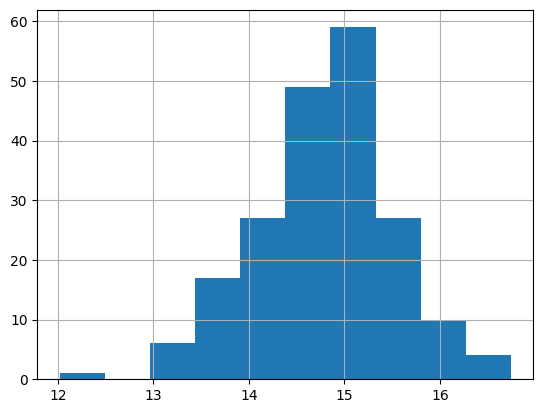

In [82]:
cell_sim_protein_data["Mek"].hist()

### Initial Analysis

KeyError: 'cell_type'

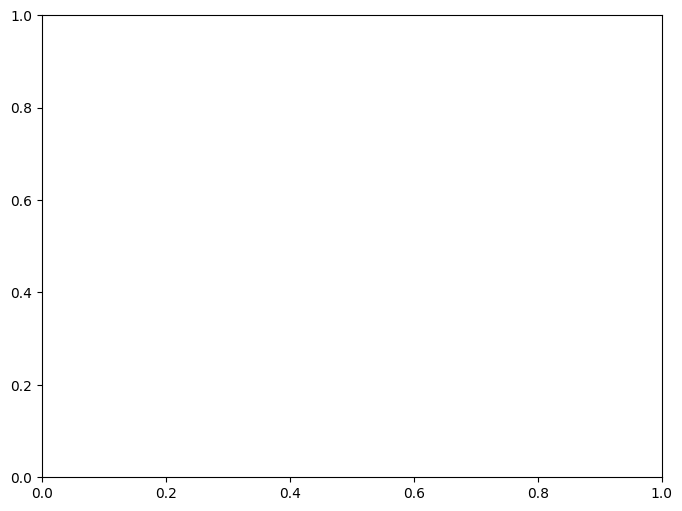

In [62]:
fig, ax = plt.subplots(figsize=(8,6))

plot_data = cell_sim_protein_data.dropna()
x = plot_data[plot_data["cell_type"] == "0"]["Ras"]
y = plot_data[plot_data["cell_type"] == "0"]["Erk"]

ax.scatter(x, y)
m, b = np.polyfit(x.values, y.values, 1)
ax.plot(x, m*x + b, color="red", lw=4)

ax.set_title("Regression Analysis", size=24)
ax.set_xlabel("Ras", size=24)
ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

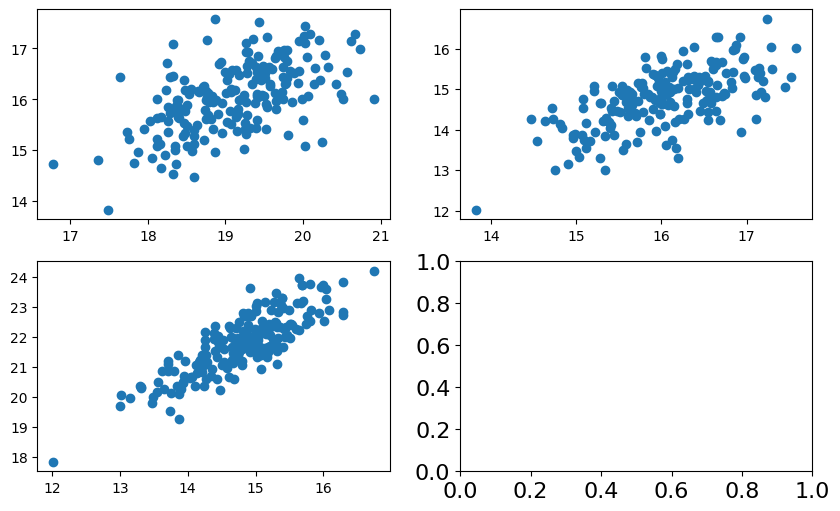

In [83]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

ras = cell_sim_protein_data["Ras"]
raf = cell_sim_protein_data["Raf"]
mek = cell_sim_protein_data["Mek"]
erk = cell_sim_protein_data["Erk"]

ax[0,0].scatter(ras, raf)
ax[0,1].scatter(raf, mek)
ax[1,0].scatter(mek, erk)

# ax.set_title("P(Erk | Ras)", size=24)
# ax.set_xlabel("Ras", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Run inference

In [89]:
# pyro.clear_param_store()

lvm = LVM(cell_sim_protein_data.loc[:, 
        [i for i in cell_sim_protein_data.columns if i not in ["EGF", "IGF", "originalRUN"]]], 
          y0_graph_bulk)
lvm.prepare_graph()
lvm.prepare_data()
lvm.fit_model(num_steps=2000)

lvm.intervention({"Ras": 15}, "Erk")
first_int = lvm.intervention_samples
lvm.intervention({"Ras": 20}, "Erk")
second_int = lvm.intervention_samples

# lvm.intervention("Ras", "Erk", 10)
# first_int = lvm.intervention_samples

# lvm.intervention("Ras", "Erk", 20)
# second_int = lvm.intervention_samples

Step 0: Loss = -2189.350615590811
Step 100: Loss = -2692.8666622638702
Step 200: Loss = -3097.8871162086725
Step 300: Loss = -3401.6606005616486
Step 400: Loss = -3493.2966988496482
Step 500: Loss = -3605.3733897060156
Step 600: Loss = -3662.805848285556
Step 700: Loss = -3702.6315688490868
Step 800: Loss = -3713.8884800449014
Step 900: Loss = -3797.09945982974
Stopping early at step 935 with loss -3762.7345245443285


In [54]:
lvm.parameters

,parameter,mean,scale
0,SOS_intercept,12.457932,0.3886727
1,SOS_scale,1.7861246,0.0474039
2,Ras_intercept,1.1918005,0.039588112
3,Ras_SOS_coef,0.7017286,0.0022285325
4,Ras_scale,-0.6343336,0.05288697
5,PI3K_intercept,2.299162,0.064959176
6,PI3K_Ras_coef,1.7100228,0.0048169894
7,PI3K_scale,-0.12635413,0.047800627
8,Akt_intercept,0.7917411,0.0380241
9,Akt_PI3K_coef,0.7861072,0.0014955517


In [90]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

4.3570385

[Text(1, 0.0, ''),
 Text(1, 200.0, ''),
 Text(1, 400.0, ''),
 Text(1, 600.0, ''),
 Text(1, 800.0, ''),
 Text(1, 1000.0, ''),
 Text(1, 1200.0, '')]

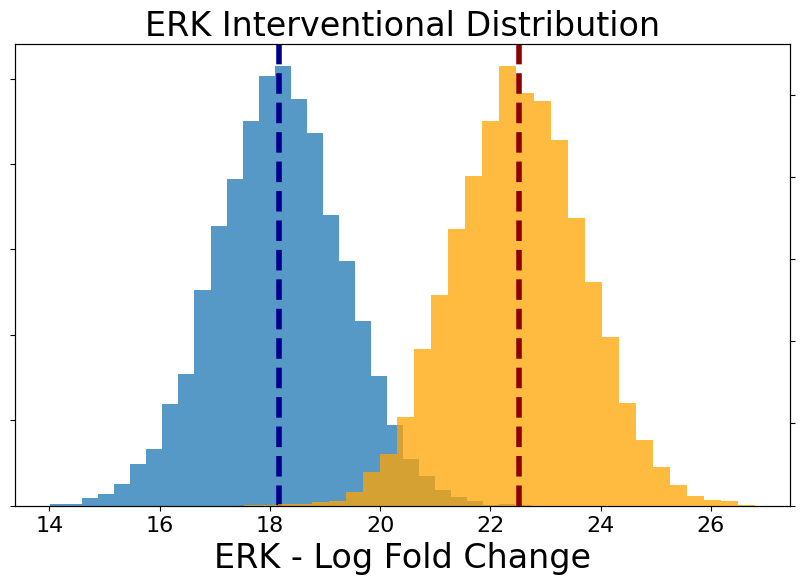

In [94]:
fig, ax = plt.subplots(figsize=(10,6))

adj = 0#np.mean(np.array(cell_sim_protein_data.loc[:, "Erk"].values))

ax.hist(np.array(first_int) - adj, bins=30, alpha=.75, label="Observational Data")
ax.axvline(np.mean(np.array(first_int)) - adj, color="darkblue", linestyle="dashed", lw=4)

ax2 = ax.twinx()
ax2.hist(np.array(second_int) - adj, bins=30, alpha=.75, label="Interventional Distribution", color="orange")
ax2.axvline(np.mean(np.array(second_int)) - adj, color="darkred", linestyle="dashed", lw=4)

# ax.legend(fontsize=20)
ax.set_title("ERK Interventional Distribution", size=24)
ax.set_xlabel("ERK - Log Fold Change", size=24)
# ax.set_ylabel("Erk", size=24)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.set_yticklabels([])
ax2.set_yticklabels([])

# ax.set_xlim(-5,40)
# ax.set_ylim(0,1800)

## Cell Type - Single cell

### Analysis

In [28]:
single_cell_lm = linear_model.LinearRegression()

fit_data = pd.concat([cell_sim_protein_data[["Ras", "Erk"]], 
               pd.get_dummies(cell_sim_protein_data["cell_type"].values)], 
              axis=1).dropna()
x = fit_data.drop(columns=["Erk"])
y = fit_data["Erk"]
single_cell_lm.fit(x, y)

bulk_lm = linear_model.LinearRegression()
x = cell_sim_protein_data.dropna()[["Ras"]]
y = cell_sim_protein_data.dropna()[["Erk"]]
bulk_lm.fit(x, y)

LinearRegression()

Text(0, 0.5, 'Erk')

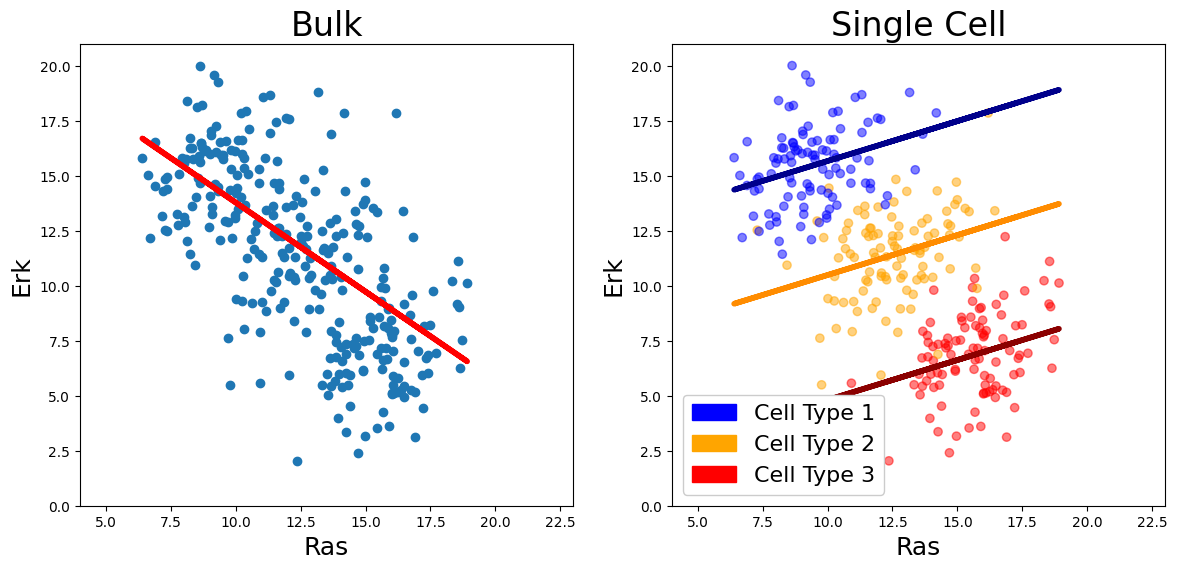

In [29]:
## Plot
fig, ax = plt.subplots(1, 2, figsize=(14,6))

colors = np.where(cell_sim_protein_data["cell_type"] == "0", "Red", 
                  np.where(cell_sim_protein_data["cell_type"] == "1", "Orange", "Blue"))

ax[0].scatter(cell_sim_protein_data["Ras"], cell_sim_protein_data["Erk"])
ax[1].scatter(cell_sim_protein_data["Ras"], cell_sim_protein_data["Erk"], 
              c=colors, alpha=.5)

ax[0].plot(cell_sim_protein_data["Ras"], 
           bulk_lm.coef_[0]*cell_sim_protein_data["Ras"] + bulk_lm.intercept_[0], 
           color="red", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[1], 
           color="darkred", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[2], 
           color="darkOrange", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[3], 
           color="darkBlue", lw=4)

red_patch = mpatches.Patch(color='red', label='Cell Type 3')
orange_patch = mpatches.Patch(color='orange', label='Cell Type 2')
blue_patch = mpatches.Patch(color='blue', label='Cell Type 1')

ax[1].legend(handles=[blue_patch, orange_patch, red_patch], fontsize=16, loc="lower left", framealpha=1.)

ax[0].set_xlim(4,23)
ax[1].set_xlim(4,23)
ax[0].set_ylim(0,21)
ax[1].set_ylim(0,21)

ax[0].set_title("Bulk", fontsize=24)
ax[1].set_title("Single Cell", fontsize=24)

ax[0].set_xlabel("Ras", fontsize=18)
ax[1].set_xlabel("Ras", fontsize=18)

ax[0].set_ylabel("Erk", fontsize=18)
ax[1].set_ylabel("Erk", fontsize=18)

# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

### Run inference

In [50]:
datasets = {"Cell1" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "0"].iloc[:,1:-1].reset_index(drop=True), 
            "Cell2" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "1"].iloc[:,1:-1].reset_index(drop=True),
            "Cell3" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "2"].iloc[:,1:-1].reset_index(drop=True)}

intervention_results = dict()

for name, data in datasets.items():
    pyro.clear_param_store()
    lvm = LVM(data, y0_graph_bulk)
    lvm.prepare_graph()
    lvm.prepare_data()
    lvm.fit_model(num_steps=4000)
    
    lvm.intervention("Ras", "Erk", 10)
    first_int = lvm.intervention_samples
    
    lvm.intervention("Ras", "Erk", 20)
    second_int = lvm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, lvm]

starting training
83944.71402535588
977.4751296043396
210.00138806551695
-55.54429815709591
-240.49085379764438
-296.88149074465036
-454.5723410695791
-518.7043964751065
-555.3010102659464
-613.1855071932077
-657.9930624812841
-710.3242057077587
-757.3370053190738
-748.8604367040098
-748.2170298732817
-808.0041689872742
-826.7924625463784
-827.8077148869634
-856.7683312520385
-876.1536559313536
-878.6185589469969
-931.5368898883462
-897.0950447507203
-910.1539589352906
-916.6462170481682
-911.0635607503355
-926.3844559639692
-924.8381802402437
-898.326901126653
-929.6027599163353
-940.1063347272575
-952.0998110175133
-957.5406628958881
-958.9827367290854
-956.6104806363583
-982.2340436577797
-958.4073623865843
-951.6884074509144
-975.8052192460746
-965.325099023059
starting training
88254.38093875162
1040.307288594544
137.30525048449636
-153.0908596739173
-324.0158685259521
-465.38423203118145
-596.4795889407396
-630.7502348888665
-670.6014800444245
-744.27008670941
-765.9532107096165


Text(0.5, 0, 'Erk - Log Intensity')

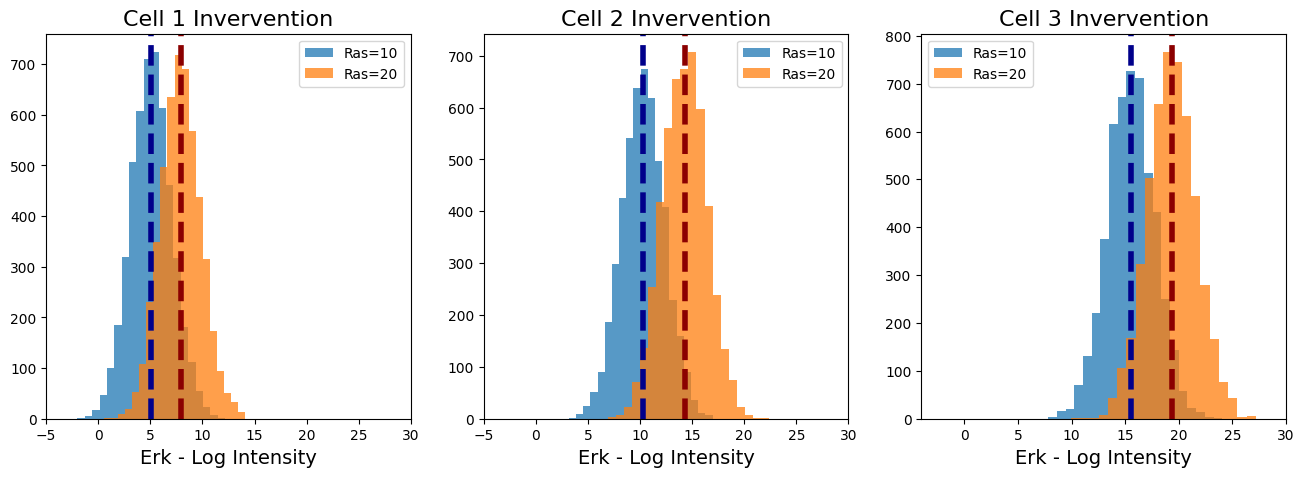

In [51]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

ax[0].hist(np.array(intervention_results["Cell1"][0]), label="Ras=10", alpha=.75, bins=20)
ax[0].axvline(np.mean(np.array(intervention_results["Cell1"][0])), color="darkblue", linestyle="dashed", lw=4)
ax[0].hist(np.array(intervention_results["Cell1"][1]), label="Ras=20", alpha=.75, bins=20)
ax[0].axvline(np.mean(np.array(intervention_results["Cell1"][1])), color="darkred", linestyle="dashed", lw=4)
ax[0].legend()

ax[1].hist(np.array(intervention_results["Cell2"][0]), label="Ras=10", alpha=.75, bins=20)
ax[1].axvline(np.mean(np.array(intervention_results["Cell2"][0])), color="darkblue", linestyle="dashed", lw=4)
ax[1].hist(np.array(intervention_results["Cell2"][1]), label="Ras=20", alpha=.75, bins=20)
ax[1].axvline(np.mean(np.array(intervention_results["Cell2"][1])), color="darkred", linestyle="dashed", lw=4)
ax[1].legend()

ax[2].hist(np.array(intervention_results["Cell3"][0]), label="Ras=10", alpha=.75, bins=20)
ax[2].axvline(np.mean(np.array(intervention_results["Cell3"][0])), color="darkblue", linestyle="dashed", lw=4)
ax[2].hist(np.array(intervention_results["Cell3"][1]), label="Ras=20", alpha=.75, bins=20)
ax[2].axvline(np.mean(np.array(intervention_results["Cell3"][1])), color="darkred", linestyle="dashed", lw=4)
ax[2].legend()

ax[0].set_title("Cell 1 Invervention", fontsize=16)
ax[1].set_title("Cell 2 Invervention", fontsize=16)
ax[2].set_title("Cell 3 Invervention", fontsize=16)
ax[0].set_xlim(-5, 30)
ax[1].set_xlim(-5, 30)
ax[2].set_xlim(-4, 30)
ax[0].set_xlabel("Erk - Log Intensity", size=14)
ax[1].set_xlabel("Erk - Log Intensity", size=14)
ax[2].set_xlabel("Erk - Log Intensity", size=14)
# ax.set_ylabel("Erk", size=24)

In [55]:
np.mean(np.array(intervention_results["Cell1"][1])) - np.mean(np.array(intervention_results["Cell1"][0]))

2.820404

In [56]:
np.mean(np.array(intervention_results["Cell2"][1])) - np.mean(np.array(intervention_results["Cell2"][0]))

3.9859638

In [57]:
np.mean(np.array(intervention_results["Cell3"][1])) - np.mean(np.array(intervention_results["Cell3"][0]))

3.7919397

## Low vs High Replicates

Compare causal effect estimation using different numbers of replicates.

### Simulate Data

In [58]:
low_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=10, seed=1)
med_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=50, seed=0)
high_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=250, seed=0)
very_high_rep_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, n=1000, seed=0)

simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...


In [48]:
low_rep_data["Feature_data"].to_csv("../../data/IGF_pathway/low_rep_feature_data.csv", index=False)
med_rep_data["Feature_data"].to_csv("../../data/IGF_pathway/med_rep_feature_data.csv", index=False)
high_rep_data["Feature_data"].to_csv("../../data/IGF_pathway/high_rep_feature_data.csv", index=False)
very_high_rep_data["Feature_data"].to_csv("../../data/IGF_pathway/very_high_rep_feature_data.csv", index=False)

In [25]:
low_rep_protein_data = pd.read_csv("../../data/IGF_pathway/low_rep_protein_data.csv")
med_rep_protein_data = pd.read_csv("../../data/IGF_pathway/med_rep_protein_data.csv")
high_rep_protein_data = pd.read_csv("../../data/IGF_pathway/high_rep_protein_data.csv")
very_high_protein_data = pd.read_csv("../../data/IGF_pathway/very_high_rep_protein_data.csv")

### Initial Analysis

Text(0, 0.5, 'Erk')

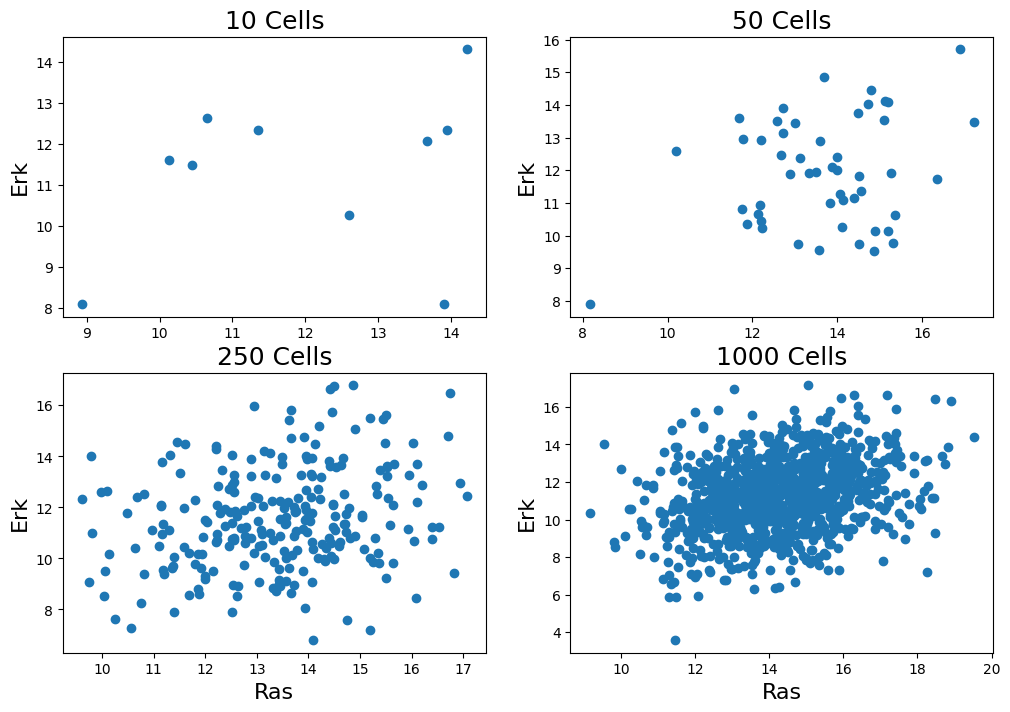

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].scatter(low_rep_protein_data["Ras"], low_rep_protein_data["Erk"])
ax[0,1].scatter(med_rep_protein_data["Ras"], med_rep_protein_data["Erk"])
ax[1,0].scatter(high_rep_protein_data["Ras"], high_rep_protein_data["Erk"])
ax[1,1].scatter(very_high_protein_data["Ras"], very_high_protein_data["Erk"])

ax[0,0].set_title("10 Cells", fontsize=18)
ax[0,1].set_title("50 Cells", fontsize=18)
ax[1,0].set_title("250 Cells", fontsize=18)
ax[1,1].set_title("1000 Cells", fontsize=18)

# ax[0,0].set_xlabel("Raf", fontsize=16)
# ax[0,1].set_xlabel("Raf", fontsize=16)
ax[1,0].set_xlabel("Ras", fontsize=16)
ax[1,1].set_xlabel("Ras", fontsize=16)

ax[0,0].set_ylabel("Erk", fontsize=16)
ax[0,1].set_ylabel("Erk", fontsize=16)
ax[1,0].set_ylabel("Erk", fontsize=16)
ax[1,1].set_ylabel("Erk", fontsize=16)

### Run inference

In [26]:
low_rep_protein_data

,originalRUN,Akt,EGF,Erk,IGF,Mek,PI3K,Raf,Ras,SOS
0,0_Obs,25.541469,22.544742,8.098334,20.833942,5.212930,31.613607,NaN,13.892606,21.415226
1,1_Obs,16.477208,15.836437,11.606401,10.267196,8.118344,20.397819,6.892966,10.127669,13.295539
2,2_Obs,18.301462,16.087191,12.352026,15.480366,8.553322,23.883848,6.408573,11.354861,16.330760
3,3_Obs,19.903344,14.452800,11.477849,15.295455,7.638599,24.962124,NaN,10.451489,14.840083
4,4_Obs,24.007178,20.267929,12.332305,19.848926,8.527106,30.246637,6.166153,13.935209,21.459604
5,5_Obs,16.338313,10.767090,8.104856,13.147944,NaN,18.960795,4.674204,8.940952,10.153928
6,6_Obs,24.176724,22.906141,10.268622,15.930333,7.463310,29.075529,5.666058,12.593158,19.667630
7,7_Obs,21.358586,15.388085,12.641349,13.814043,8.498865,25.195187,5.623740,10.648140,13.074143
8,8_Obs,22.813212,18.628823,14.306589,16.574259,10.167880,27.995375,8.558832,14.207754,17.342597
9,9_Obs,23.550391,16.923595,12.071865,18.196063,NaN,28.178875,4.245212,13.664090,18.090786


In [51]:
datasets = {"low" : low_rep_protein_data.iloc[:,1:], "med" : med_rep_protein_data.iloc[:,1:], 
            "high" : high_rep_protein_data.iloc[:,1:], "very_high" : very_high_protein_data.iloc[:,1:]}

intervention_results = dict()

for name, data in datasets.items():
    # data = pd.melt(data, id_vars='originalRUN', value_vars=['Akt','EGF','Erk',
    #                                                         'IGF','Mek','PI3K',
    #                                                         'Raf','Ras','SOS'],
    #                                                         var_name='Protein',
    #                                                         value_name='LogIntensities')
    # data = norm.normalize(data)
    # data = gs.prep_msstats_data(data, gene_map=None, parse_gene=False)
    pyro.clear_param_store()
    lvm = LVM(data, y0_graph_bulk)
    lvm.prepare_graph()
    lvm.prepare_data()
    lvm.fit_model(num_steps=2000)
    
    lvm.intervention({"Ras": 2}, "Erk")
    first_int = lvm.posterior_samples
    second_int = lvm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, lvm]

Step 0: Loss = 9518.528020825936
Step 100: Loss = 201.20355162024498
Step 200: Loss = 130.07447033375502
Step 300: Loss = 66.69215976446867
Step 400: Loss = 43.053706251084805
Step 500: Loss = 48.8661416657269
Step 600: Loss = 53.24169673770666
Stopping early at step 626 with loss 50.283434204757214
Step 0: Loss = 40851.04219049774
Step 100: Loss = 636.0138088911772
Step 200: Loss = 264.47095246240497
Step 300: Loss = 129.2478162497282
Step 400: Loss = 30.99229296296835
Step 500: Loss = -8.841774210333824
Step 600: Loss = -62.92853408306837
Step 700: Loss = -95.97518013417721
Step 800: Loss = -130.48062696680427
Stopping early at step 817 with loss -122.09861125797033
Step 0: Loss = 245520.4001877755
Step 100: Loss = 2638.6710086762905
Step 200: Loss = 654.5343722254038
Step 300: Loss = -119.2471027970314
Step 400: Loss = -425.3541945107281
Step 500: Loss = -793.9599289894104
Step 600: Loss = -1004.7293358109891
Step 700: Loss = -1200.8120914343745
Step 800: Loss = -1269.2372062504292


### Compare to ground truth

Text(0.5, 0, 'Erk - Log Intensity')

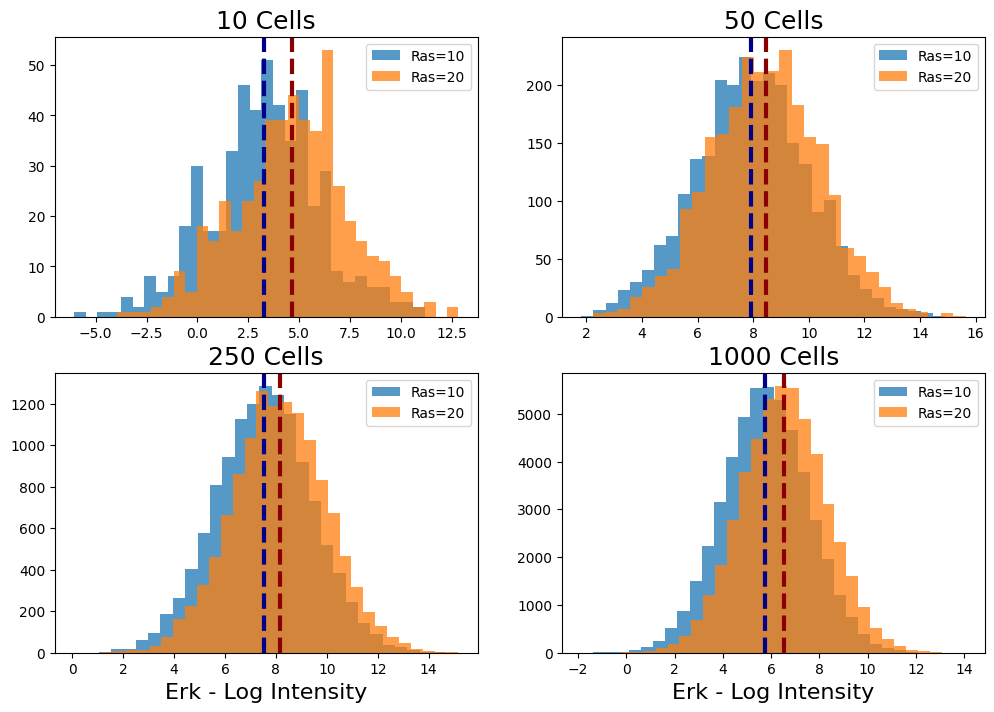

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].hist(intervention_results["low"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,0].hist(intervention_results["low"][1], label="Ras=20", alpha=.75, bins=30)
# ax[0,0].axvline(x=intervention_results["low"][0].mean(), color="darkblue", lw=3, linestyle="--")
# ax[0,0].axvline(x=intervention_results["low"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[0,0].axvline(x=intervention_results["low"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[0,0].axvline(x=intervention_results["low"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[0,0].legend()

ax[0,1].hist(intervention_results["med"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,1].hist(intervention_results["med"][1], label="Ras=20", alpha=.75, bins=30)
# ax[0,1].axvline(x=intervention_results["med"][0].mean(), color="darkblue", lw=3, linestyle="--")
# ax[0,1].axvline(x=intervention_results["med"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[0,1].axvline(x=intervention_results["med"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[0,1].axvline(x=intervention_results["med"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[0,1].legend()

ax[1,0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=30)
# ax[1,0].axvline(x=intervention_results["high"][0].mean(), color="darkblue", lw=3, linestyle="--")
# ax[1,0].axvline(x=intervention_results["high"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[1,0].axvline(x=intervention_results["high"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[1,0].axvline(x=intervention_results["high"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[1,0].legend()

ax[1,1].hist(intervention_results["very_high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,1].hist(intervention_results["very_high"][1], label="Ras=20", alpha=.75, bins=30)
# ax[1,1].axvline(x=intervention_results["very_high"][0].mean(), color="darkblue", lw=3, linestyle="--")
# ax[1,1].axvline(x=intervention_results["very_high"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[1,1].axvline(x=intervention_results["very_high"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[1,1].axvline(x=intervention_results["very_high"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[1,1].legend(fontsize=20)

np.mean(gt_int_cell[1]) - np.mean(gt_int_cell[0])

# ax[0,0].set_xlim(0,30)
# ax[0,1].set_xlim(0,30)
# ax[1,0].set_xlim(0,30)
# ax[1,1].set_xlim(0,30)

plt.legend()
ax[0,0].set_title("10 Cells", fontsize=18)
ax[0,1].set_title("50 Cells", fontsize=18)
ax[1,0].set_title("250 Cells", fontsize=18)
ax[1,1].set_title("1000 Cells", fontsize=18)

ax[1,0].set_xlabel("Erk - Log Intensity", size=16)
ax[1,1].set_xlabel("Erk - Log Intensity", size=16)

## Low vs High Replicates - Bulk

### Simulate data

In [18]:
low_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                  cell_type=True, n_cells=3, n=30, seed=0)
med_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                  cell_type=True, n_cells=3, n=100, seed=0)
high_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                   cell_type=True, n_cells=3, n=250, seed=0)
very_high_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                                        cell_type=True, n_cells=3, n=1000, seed=1)

simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...


KeyboardInterrupt: 

In [ ]:
low_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/low_rep_bulk_feature_data.csv", index=False)
med_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/med_rep_bulk_feature_data.csv", index=False)
high_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/high_rep_bulk_feature_data.csv", index=False)
very_high_rep_bulk_data["Feature_data"].to_csv("../data/IGF_pathway/very_high_rep_bulk_feature_data.csv", index=False)

In [23]:
low_rep_bulk_protein_data = pd.read_csv("../../data/IGF_pathway/low_rep_bulk_protein_data.csv")
med_rep_bulk_protein_data = pd.read_csv("../../data/IGF_pathway/med_rep_bulk_protein_data.csv")
high_rep_bulk_protein_data = pd.read_csv("../../data/IGF_pathway/high_rep_bulk_protein_data.csv")
very_high_bulk_protein_data = pd.read_csv("../../data/IGF_pathway/very_high_rep_bulk_protein_data.csv")

### Analysis

Text(0, 0.5, 'Erk')

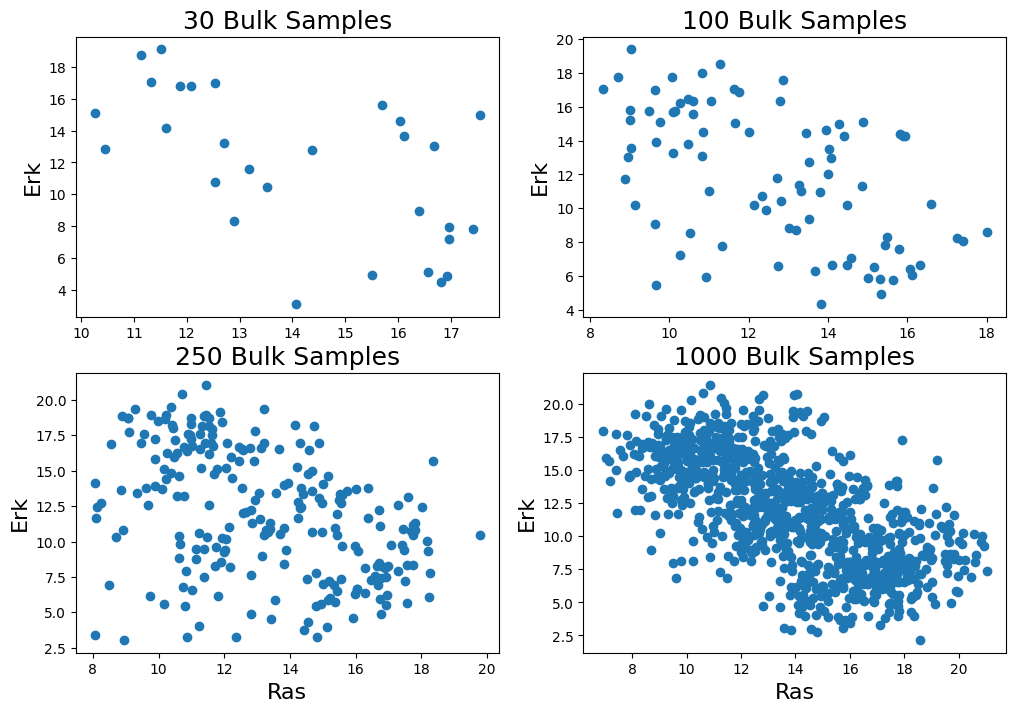

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].scatter(low_rep_bulk_protein_data["Ras"], low_rep_bulk_protein_data["Erk"])
ax[0,1].scatter(med_rep_bulk_protein_data["Ras"], med_rep_bulk_protein_data["Erk"])
ax[1,0].scatter(high_rep_bulk_protein_data["Ras"], high_rep_bulk_protein_data["Erk"])
ax[1,1].scatter(very_high_bulk_protein_data["Ras"], very_high_bulk_protein_data["Erk"])

ax[0,0].set_title("30 Bulk Samples", fontsize=18)
ax[0,1].set_title("100 Bulk Samples", fontsize=18)
ax[1,0].set_title("250 Bulk Samples", fontsize=18)
ax[1,1].set_title("1000 Bulk Samples", fontsize=18)

# ax[0,0].set_xlabel("Raf", fontsize=16)
# ax[0,1].set_xlabel("Raf", fontsize=16)
ax[1,0].set_xlabel("Ras", fontsize=16)
ax[1,1].set_xlabel("Ras", fontsize=16)

ax[0,0].set_ylabel("Erk", fontsize=16)
ax[0,1].set_ylabel("Erk", fontsize=16)
ax[1,0].set_ylabel("Erk", fontsize=16)
ax[1,1].set_ylabel("Erk", fontsize=16)

### Run inference

In [25]:
datasets = {"low" : low_rep_bulk_protein_data.iloc[:,1:], "med" : med_rep_bulk_protein_data.iloc[:,1:], 
            "high" : high_rep_bulk_protein_data.iloc[:,1:], "very_high" : very_high_bulk_protein_data.iloc[:,1:]}

intervention_results = dict()

for name, data in datasets.items():
    pyro.clear_param_store()
    lvm = LVM(data, y0_graph_bulk)
    lvm.prepare_graph()
    lvm.prepare_data()
    lvm.fit_model(num_steps=2000)
    
    lvm.intervention("Ras", "Erk", 10)
    first_int = lvm.intervention_samples
    
    lvm.intervention("Ras", "Erk", 20)
    second_int = lvm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, lvm]

starting training
28569.250364203006
416.6307812333107
248.0248228162527
169.34015357494354
104.43817307054996
88.85601255297661
66.8567411005497
36.40215255320072
36.43407303094864
28.906294107437134
22.366227447986603
21.302482962608337
18.68332016468048
-4.042477786540985
-4.37084835767746
13.230473741889
7.00207057595253
-2.7246507555246353
-2.4124915152788162
-8.466946333646774
starting training
82675.56834294193
1837.8185758590698
1088.1840256154537
850.4179688841105
719.1230039596558
608.7976654618979
539.1525463461876
522.1148848682642
509.74803064763546
477.8437864780426
451.6499222368002
432.55452205240726
429.9567832201719
413.7659131884575
383.01724115014076
350.15042643249035
396.29991832375526
383.95504182577133
380.77918753027916
355.69057731330395
starting training
229018.1629309156
3719.2624411582947
1988.7913024425507
1338.2980552762747
885.5917420387268
623.0041740983725
466.70688493549824
296.0607136785984
161.50019666552544
113.07196480035782
60.58683927357197
-62.

Text(0.5, 0, 'Erk - Log Intensity')

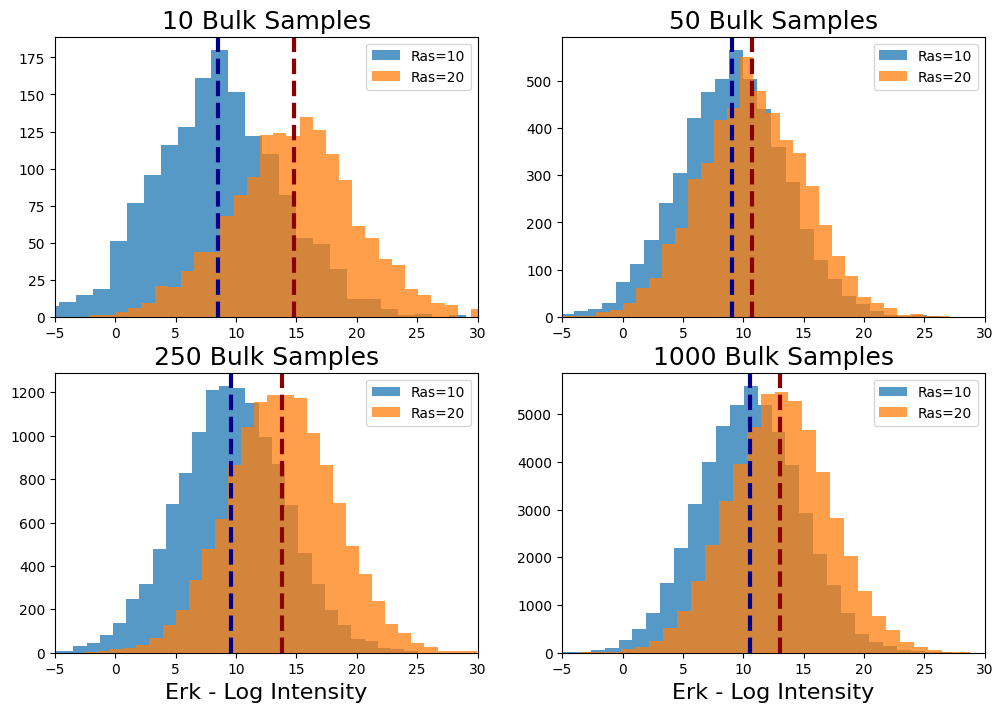

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].hist(intervention_results["low"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,0].hist(intervention_results["low"][1], label="Ras=20", alpha=.75, bins=30)
ax[0,0].axvline(x=intervention_results["low"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[0,0].axvline(x=intervention_results["low"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[0,0].legend()

ax[0,1].hist(intervention_results["med"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,1].hist(intervention_results["med"][1], label="Ras=20", alpha=.75, bins=30)
ax[0,1].axvline(x=intervention_results["med"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[0,1].axvline(x=intervention_results["med"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[0,1].legend()

ax[1,0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=30)
ax[1,0].axvline(x=intervention_results["high"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[1,0].axvline(x=intervention_results["high"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[1,0].legend()

ax[1,1].hist(intervention_results["very_high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,1].hist(intervention_results["very_high"][1], label="Ras=20", alpha=.75, bins=30)
ax[1,1].axvline(x=intervention_results["very_high"][0].mean(), color="darkblue", lw=3, linestyle="--")
ax[1,1].axvline(x=intervention_results["very_high"][1].mean(), color="darkred", lw=3, linestyle="--")
ax[1,1].legend()

ax[0,0].set_xlim(-5,30)
ax[0,1].set_xlim(-5,30)
ax[1,0].set_xlim(-5,30)
ax[1,1].set_xlim(-5,30)

ax[0,0].set_title("10 Bulk Samples", fontsize=18)
ax[0,1].set_title("50 Bulk Samples", fontsize=18)
ax[1,0].set_title("250 Bulk Samples", fontsize=18)
ax[1,1].set_title("1000 Bulk Samples", fontsize=18)

ax[1,0].set_xlabel("Erk - Log Intensity", size=16)
ax[1,1].set_xlabel("Erk - Log Intensity", size=16)

## High dynamic range

In [42]:
## Coefficients for relations
cell_coef_high_range = {'EGF': {'intercept': 18., "error": 8},
              'IGF': {'intercept': 17., "error": 8},
              'SOS': {'intercept': -4, "error": 1, 
                      'EGF': 0.6, 'IGF': 0.6,},
              'Ras': {'intercept': 5, "error": 1, 'SOS': .5, "cell_type" : [3, 0, -3]},
              'PI3K': {'intercept': 1.6, "error": 1, 
                       'EGF': .5, 'IGF': 0.5, 'Ras': .5,},
              'Akt': {'intercept': 2., "error": 1, 'PI3K': 0.75, },
              'Raf': {'intercept': 2, "error": 1,
                      'Ras': 0.8, 'Akt': -.4, "cell_type" : [-2, 0, 2]},
              'Mek': {'intercept': 3., "error": 1, 'Raf': 0.75, "cell_type" : [-2, 0, 2]},
              'Erk': {'intercept': 4., "error": 1, 'Mek': 1.2, "cell_type" : [-2, 0, 2]}
             }

In [43]:
low_rep_range_data = simulate_data(cell_type_graph, coefficients=cell_coef_high_range, include_missing=True, 
                                  cell_type=True, n_cells=3, n=30, seed=0)
med_rep_range_data = simulate_data(cell_type_graph, coefficients=cell_coef_high_range, include_missing=True, 
                                  cell_type=True, n_cells=3, n=100, seed=0)
high_rep_range_data = simulate_data(cell_type_graph, coefficients=cell_coef_high_range, include_missing=True, 
                                   cell_type=True, n_cells=3, n=250, seed=0)
# very_high_rep_bulk_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
#                                         cell_type=True, n_cells=3, n=1000, seed=1)

simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...


In [48]:
low_rep_range_data["Feature_data"].to_csv("../data/IGF_pathway/low_rep_range_feature_data.csv", index=False)
med_rep_range_data["Feature_data"].to_csv("../data/IGF_pathway/med_rep_range_feature_data.csv", index=False)
high_rep_range_data["Feature_data"].to_csv("../data/IGF_pathway/high_rep_range_feature_data.csv", index=False)

In [53]:
low_rep_range_protein_data = pd.read_csv("../data/IGF_pathway/low_rep_range_protein_data.csv")
med_rep_range_protein_data = pd.read_csv("../data/IGF_pathway/med_rep_range_protein_data.csv")
high_rep_range_protein_data = pd.read_csv("../data/IGF_pathway/high_rep_range_protein_data.csv")

### Analysis

Text(0, 0.5, 'Mek')

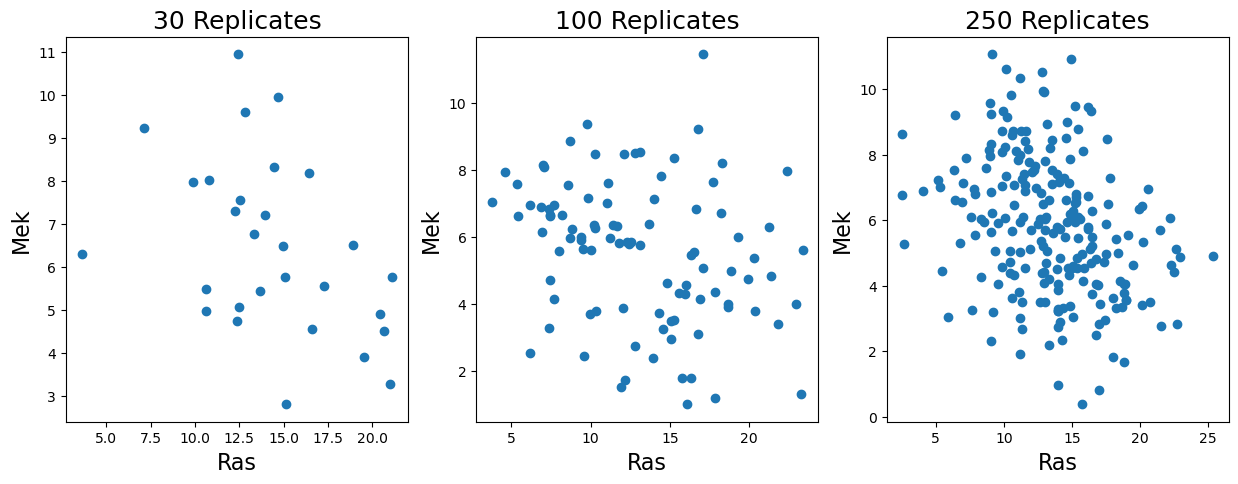

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].scatter(low_rep_range_protein_data["Ras"], low_rep_range_protein_data["Mek"])
ax[1].scatter(med_rep_range_protein_data["Ras"], med_rep_range_protein_data["Mek"])
ax[2].scatter(high_rep_range_protein_data["Ras"], high_rep_range_protein_data["Mek"])

ax[0].set_title("30 Replicates", fontsize=18)
ax[1].set_title("100 Replicates", fontsize=18)
ax[2].set_title("250 Replicates", fontsize=18)

# ax[0,0].s|et_xlabel("Raf", fontsize=16)
# ax[0,1].set_xlabel("Raf", fontsize=16)
ax[0].set_xlabel("Ras", fontsize=16)
ax[1].set_xlabel("Ras", fontsize=16)
ax[2].set_xlabel("Ras", fontsize=16)

                  
ax[0].set_ylabel("Mek", fontsize=16)
ax[1].set_ylabel("Mek", fontsize=16)
ax[2].set_ylabel("Mek", fontsize=16)

### Run inference

In [61]:
datasets = {"low" : low_rep_range_protein_data, "med" : med_rep_range_protein_data, 
            "high" : high_rep_range_protein_data}

intervention_results = dict()

for name, data in datasets.items():
    scm = SCM(data, y0_graph_bulk)
    scm.prepare_scm_input()
    scm.fit_scm(num_samples=1000, warmup_steps=3000, num_chains=4)
    
    scm.intervention("Ras", "Erk", 10)
    first_int = scm.intervention_samples
    
    scm.intervention("Ras", "Erk", 20)
    second_int = scm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, scm]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Log Intensity')

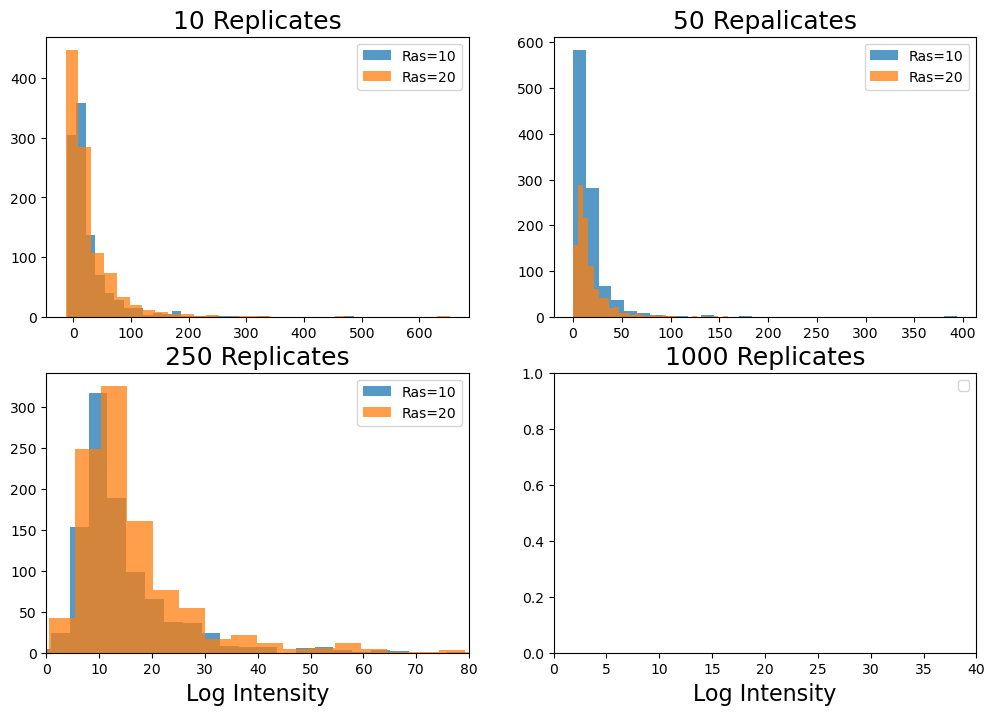

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].hist(intervention_results["low"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,0].hist(intervention_results["low"][1], label="Ras=20", alpha=.75, bins=30)
# ax[0,0].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[0,0].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[0,0].legend()

ax[0,1].hist(intervention_results["med"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,1].hist(intervention_results["med"][1], label="Ras=20", alpha=.75, bins=30)
# ax[0,1].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[0,1].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[0,1].legend()

ax[1,0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=30)
# ax[1,0].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[1,0].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[1,0].legend()

# ax[1,1].hist(intervention_results["very_high"][0], label="Ras=10", alpha=.75, bins=30)
# ax[1,1].hist(intervention_results["very_high"][1], label="Ras=20", alpha=.75, bins=30)
# ax[1,1].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[1,1].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
# ax[1,1].legend(fontsize=20)

ax[1,0].set_xlim(0,80)
ax[1,1].set_xlim(0,40)

plt.legend()
ax[0,0].set_title("10 Replicates", fontsize=18)
ax[0,1].set_title("50 Repalicates", fontsize=18)
ax[1,0].set_title("250 Replicates", fontsize=18)
ax[1,1].set_title("1000 Replicates", fontsize=18)

ax[1,0].set_xlabel("Log Intensity", fontsize=16)
ax[1,1].set_xlabel("Log Intensity", fontsize=16)

## Bad node measurements

Here we simulate a high error for Mek, which is along the causal path from Ras to Erk

In [65]:
bad_node_data = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                              add_error=True, error_node="Mek", n=250, seed=1)

simulating data...
adding feature level data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:201: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.concat([feature_level_data, pd.DataFrame({"Protein": [node],
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:201: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_level_data = pd.con

masking data...


/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:240: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MAR"] = False
/mnt/d/OneDrive - Northeastern University/northeastern/research/causal_inference/MS_causal_inference/MScausality/src/MScausality/simulation.py:246: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feature_level_data.loc[i, "MNAR"] = False


In [66]:
bad_node_data["Feature_data"].to_csv("../data/IGF_pathway/bad_node_feature_data.csv", index=False)

In [70]:
bad_node_protein_data = pd.read_csv("../data/IGF_pathway/bad_node_protein_data.csv")

### Analysis

In [71]:
single_cell_lm = linear_model.LinearRegression()

ras_erk_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Ras"]]
y = bad_node_protein_data.dropna()[["Erk"]]
ras_erk_lm.fit(x, y)

LinearRegression()

(array([ 4.,  6.,  8., 10., 12., 14., 16., 18.]),
 [Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12'),
  Text(0, 14.0, '14'),
  Text(0, 16.0, '16'),
  Text(0, 18.0, '18')])

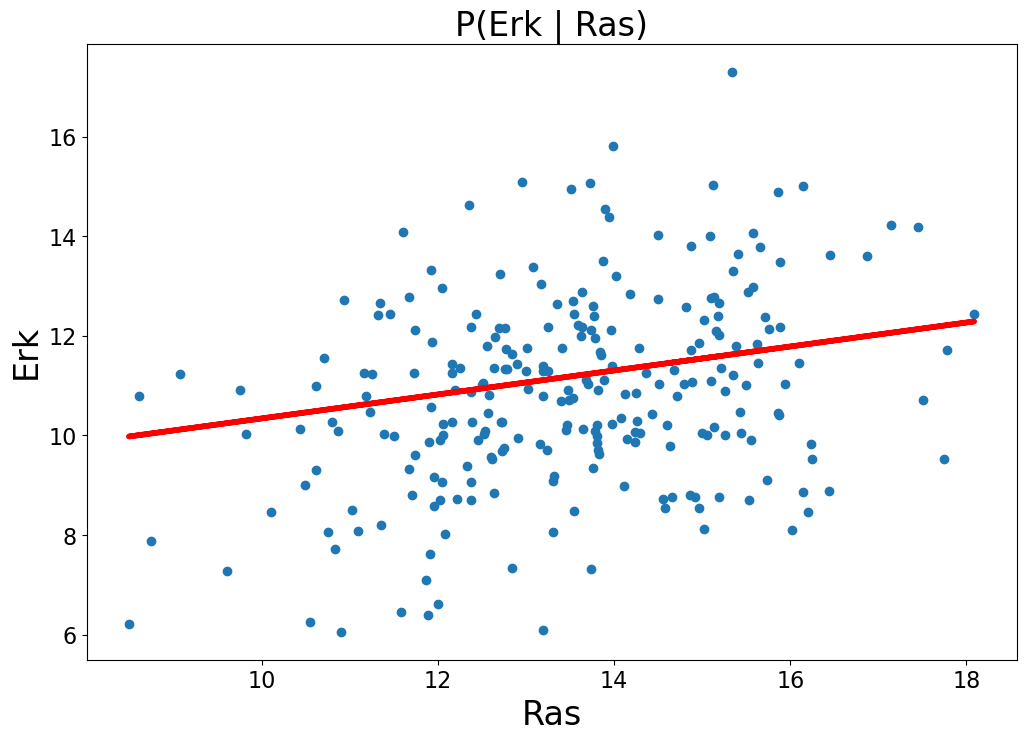

In [72]:
fig, ax = plt.subplots(figsize=(12,8))

x = bad_node_protein_data["Ras"]
y = bad_node_protein_data["Erk"]

ax.scatter(x, y)
ax.plot(bad_node_protein_data["Ras"], 
           ras_erk_lm.coef_[0]*bad_node_protein_data["Ras"] + ras_erk_lm.intercept_[0], 
           color="red", lw=4)

ax.set_title("P(Erk | Ras)", size=24)
ax.set_xlabel("Ras", size=24)
ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [73]:
single_cell_lm = linear_model.LinearRegression()

ras_raf_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Ras"]]
y = bad_node_protein_data.dropna()[["Raf"]]
ras_raf_lm.fit(x, y)

raf_mek_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Raf"]]
y = bad_node_protein_data.dropna()[["Mek"]]
raf_mek_lm.fit(x, y)

mek_erk_lm = linear_model.LinearRegression()
x = bad_node_protein_data.dropna()[["Mek"]]
y = bad_node_protein_data.dropna()[["Erk"]]
mek_erk_lm.fit(x, y)

LinearRegression()

Text(0, 0.5, 'Erk')

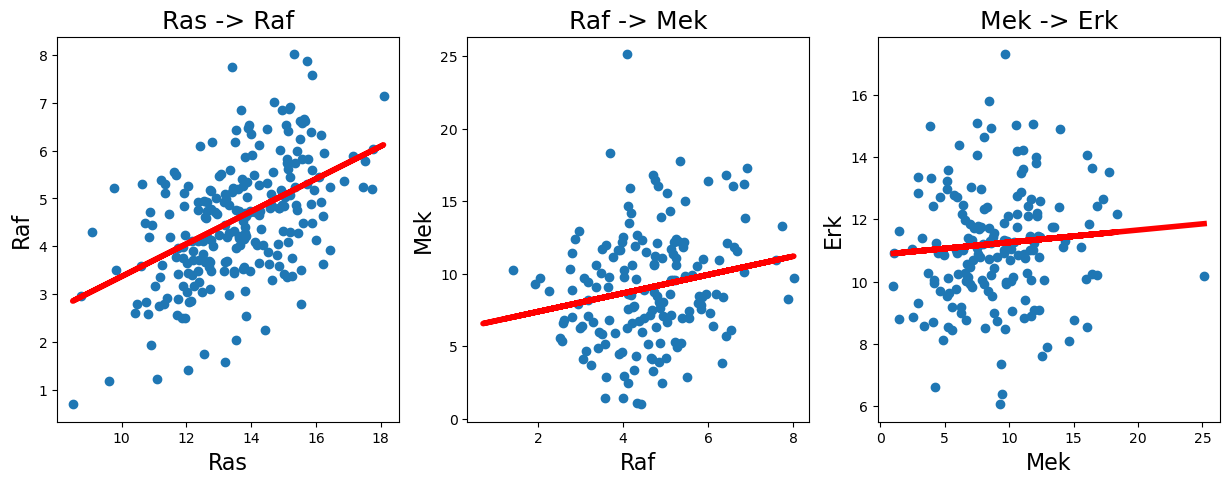

In [74]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(bad_node_protein_data["Ras"], bad_node_protein_data["Raf"])
ax[0].plot(bad_node_protein_data["Ras"], 
           ras_raf_lm.coef_[0]*bad_node_protein_data["Ras"] + ras_raf_lm.intercept_[0], 
           color="red", lw=4)

ax[1].scatter(bad_node_protein_data["Raf"], bad_node_protein_data["Mek"])
ax[1].plot(bad_node_protein_data["Raf"], 
           raf_mek_lm.coef_[0]*bad_node_protein_data["Raf"] + raf_mek_lm.intercept_[0], 
           color="red", lw=4)

ax[2].scatter(bad_node_protein_data["Mek"], bad_node_protein_data["Erk"])
ax[2].plot(bad_node_protein_data["Mek"], 
           mek_erk_lm.coef_[0]*bad_node_protein_data["Mek"] + mek_erk_lm.intercept_[0], 
           color="red", lw=4)

ax[0].set_title("Ras -> Raf", fontsize=18)
ax[1].set_title("Raf -> Mek", fontsize=18)
ax[2].set_title("Mek -> Erk", fontsize=18)

ax[0].set_xlabel("Ras", fontsize=16)                  
ax[0].set_ylabel("Raf", fontsize=16)

ax[1].set_xlabel("Raf", fontsize=16)                  
ax[1].set_ylabel("Mek", fontsize=16)

ax[2].set_xlabel("Mek", fontsize=16)                  
ax[2].set_ylabel("Erk", fontsize=16)

### Run inference

In [75]:
scm = SCM(bad_node_protein_data, y0_graph_bulk)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=4000, num_chains=4)

scm.intervention("Ras", "Erk", 10)
first_int = scm.intervention_samples

scm.intervention("Ras", "Erk", 20)
second_int = scm.intervention_samples

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [76]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

0.32441425

(0.0, 25.0)

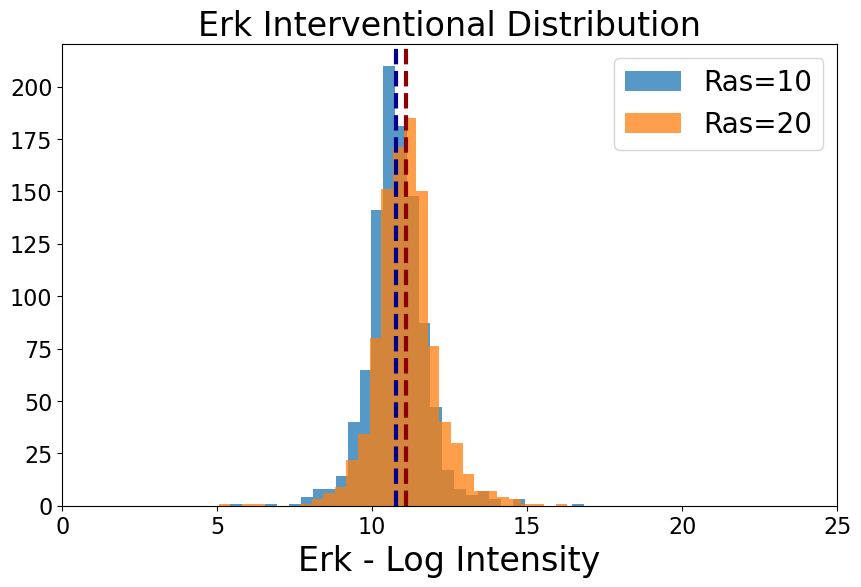

In [79]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=30, alpha=.75, label="Ras=10")
ax.hist(np.array(second_int), bins=30, alpha=.75, label="Ras=20")
ax.axvline(x=np.mean(first_int), color="darkblue", lw=3, linestyle="--")
ax.axvline(x=np.mean(second_int), color="darkred", lw=3, linestyle="--")

ax.legend(fontsize=20)
ax.set_title("Erk Interventional Distribution", size=24)
ax.set_xlabel("Erk - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


ax.set_xlim(0,25)

### Remove Mek

In [80]:
y0_no_mek = copy.copy(y0_graph_bulk)
y0_no_mek.directed.remove_edge(Variable("Raf"), Variable("Mek"))
y0_no_mek.directed.remove_edge(Variable("Mek"), Variable("Erk"))
y0_no_mek.directed.add_edge(Variable("Raf"), Variable("Erk"))

In [81]:
scm = SCM(bad_node_protein_data, y0_no_mek)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=4000, num_chains=4)

scm.intervention("Ras", "Erk", 10)
first_int = scm.intervention_samples

scm.intervention("Ras", "Erk", 20)
second_int = scm.intervention_samples

Finding root nodes...
Adding latent confounders to graph...
Determining missing obs...
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [82]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

4.8653183

(0.0, 25.0)

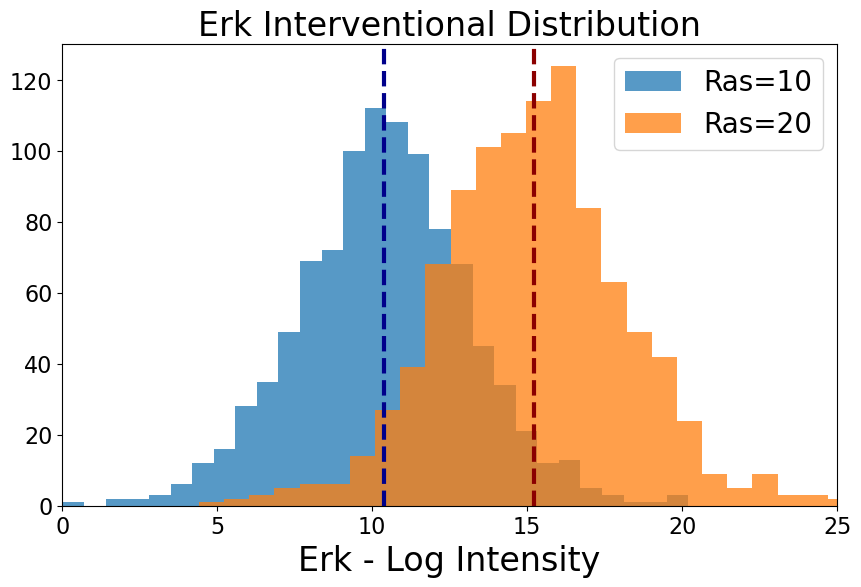

In [85]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=30, alpha=.75, label="Ras=10")
ax.hist(np.array(second_int), bins=30, alpha=.75, label="Ras=20")
ax.axvline(x=np.mean(first_int), color="darkblue", lw=3, linestyle="--")
ax.axvline(x=np.mean(second_int), color="darkred", lw=3, linestyle="--")

ax.legend(fontsize=20)
ax.set_title("Erk Interventional Distribution", size=24)
ax.set_xlabel("Erk - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


ax.set_xlim(0,25)

## Missingness

### Simulate Data

In [ ]:
high_missing_data = simulate_data(bulk_graph, coefficients=cell_coef, include_missing=True, 
                                  mar_missing_param=.1, mnar_missing_param=[-3, .15], 
                                  n=250, seed=0)

simulating data...
adding feature level data...


KeyboardInterrupt: 

In [13]:
high_missing_data["Feature_data"].to_csv("../data/IGF_pathway/high_missing_feature_data.csv", index=False)

In [5]:
high_missing_protein_data = pd.read_csv("../../data/IGF_pathway/high_missing_protein_data.csv")

### Initial Analysis

Text(0.5, 1.0, 'MNAR Curve - High Probability')

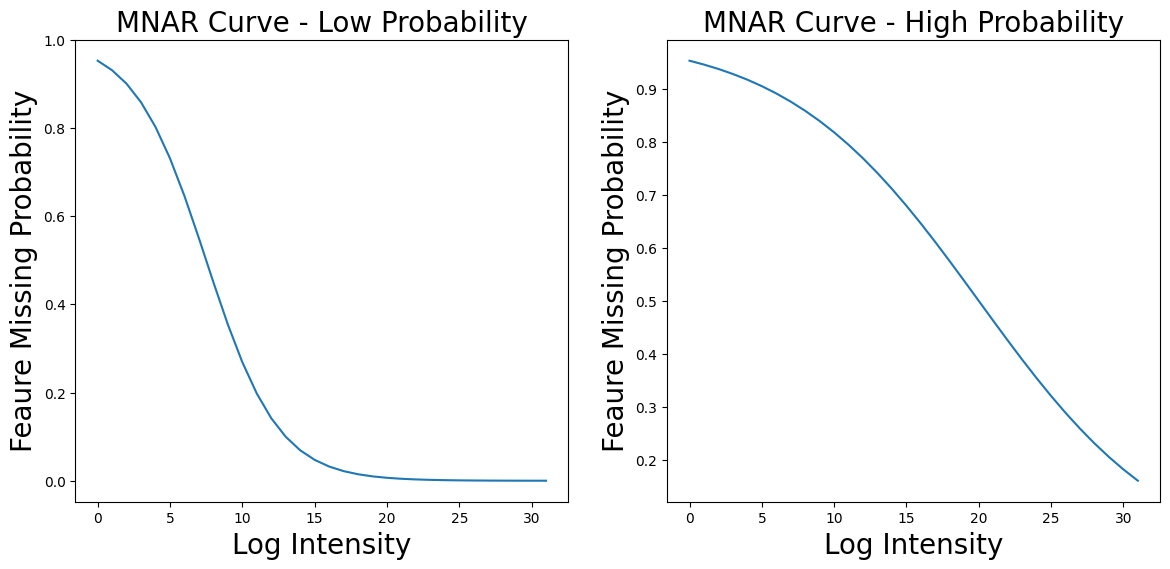

In [27]:
fig, ax = plt.subplots(1,2,figsize=(14,6))


mnar_thresh = [1 / (1 + np.exp(-3 + (.4 * i))) for i in range(0, 32)]
ax[0].plot(mnar_thresh)

mnar_thresh = [1 / (1 + np.exp(-3 + (.15 * i))) for i in range(0, 32)]
ax[1].plot(mnar_thresh)

ax[0].set_xlabel("Log Intensity", size=20)
ax[1].set_xlabel("Log Intensity", size=20)

ax[0].set_ylabel("Feaure Missing Probability", size=20)
ax[1].set_ylabel("Feaure Missing Probability", size=20)

ax[0].set_title("MNAR Curve - Low Probability", size=20)
ax[1].set_title("MNAR Curve - High Probability", size=20)

Text(0, 0.5, 'Percent Missing Replicates')

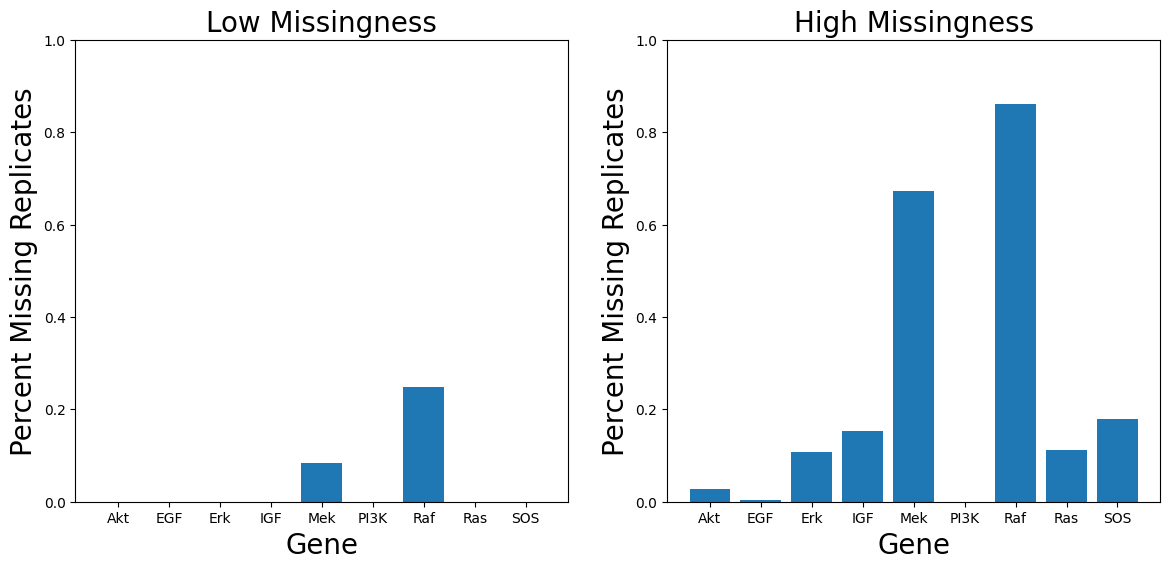

In [28]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax[0].bar(x = high_rep_protein_data.iloc[: ,1:].isnull().sum(axis = 0).index,
          height=high_rep_protein_data.iloc[: ,1:].isnull().sum(axis = 0) / len(high_rep_protein_data))

ax[1].bar(x = high_missing_protein_data.iloc[: ,1:].isnull().sum(axis = 0).index, 
       height=high_missing_protein_data.iloc[: ,1:].isnull().sum(axis = 0) / len(high_missing_protein_data))

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

ax[0].set_title("Low Missingness", size=20)
ax[1].set_title("High Missingness", size=20)

ax[0].set_xlabel("Gene", size=20)
ax[1].set_xlabel("Gene", size=20)

ax[0].set_ylabel("Percent Missing Replicates", size=20)
ax[1].set_ylabel("Percent Missing Replicates", size=20)

In [29]:
low_missing_lm = linear_model.LinearRegression()
x = high_rep_protein_data.dropna()[["Raf"]]
y = high_rep_protein_data.dropna()[["Mek"]]
low_missing_lm.fit(x, y)

high_missing_lm = linear_model.LinearRegression()
x = high_missing_protein_data.dropna()[["Raf"]]
y = high_missing_protein_data.dropna()[["Mek"]]
high_missing_lm.fit(x, y)

LinearRegression()

Text(0, 0.5, 'Mek')

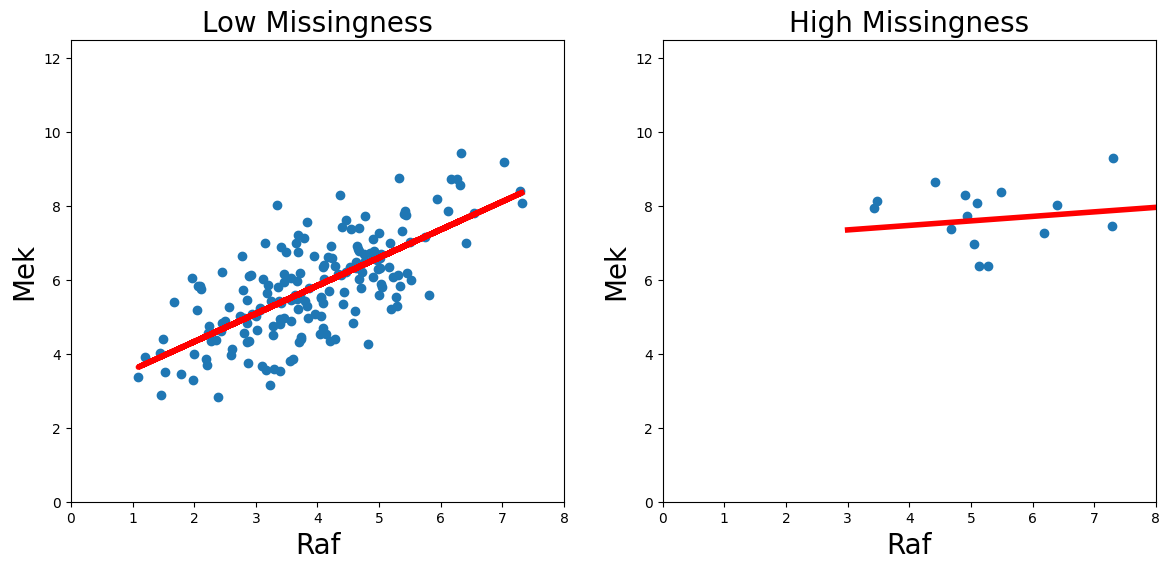

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].scatter(high_rep_protein_data["Raf"], high_rep_protein_data["Mek"])
ax[0].plot(high_rep_protein_data["Raf"], 
           low_missing_lm.coef_[0]*high_rep_protein_data["Raf"] + low_missing_lm.intercept_[0], 
           color="red", lw=4)

ax[1].scatter(high_missing_protein_data["Raf"], high_missing_protein_data["Mek"])
ax[1].plot(np.arange(3,8.5), 
           high_missing_lm.coef_[0]*np.arange(3,8.5) + high_missing_lm.intercept_[0], 
           color="red", lw=4)

ax[0].set_xlim(0,8)
ax[1].set_xlim(0,8)
ax[0].set_ylim(0,12.5)
ax[1].set_ylim(0,12.5)

ax[0].set_title("Low Missingness", size=20)
ax[1].set_title("High Missingness", size=20)

ax[0].set_xlabel("Raf", size=20)
ax[1].set_xlabel("Raf", size=20)

ax[0].set_ylabel("Mek", size=20)
ax[1].set_ylabel("Mek", size=20)

### Run inference

In [6]:
pyro.clear_param_store()
lvm = LVM(high_rep_protein_data.iloc[:,1:], y0_graph_bulk)
lvm.prepare_graph()
lvm.prepare_data()
lvm.fit_model(num_steps=4000)

lvm.intervention("Ras", "Erk", 10)
first_int = lvm.intervention_samples

lvm.intervention("Ras", "Erk", 20)
second_int = lvm.intervention_samples

low_missing_intervention_results = [first_int, second_int, lvm]

low_missing_intervention_results[1].mean() - low_missing_intervention_results[0].mean()

starting training
245520.4001877755
2456.7151985764503
376.53844376653433
-412.1444632895291
-877.2690027356148
-1256.3242064975202
-1527.092167288065
-1813.243317257613
-1946.7136450316757
-2041.658654179424
-2123.912443900481
-2208.675516292453
-2288.7143878936768
-2326.7653023190796
-2402.516814403236
-2467.5833414653316
-2529.018552571535
-2525.197556613013
-2607.0848927190527
-2598.6600791234523
-2608.082621499896
-2649.813047669828
-2647.8363337777555
-2752.3710124641657
-2698.7606443837285
-2796.0514598945156
-2740.4906817059964
-2755.873154114932
-2805.7948299646378
-2773.845112890005
-2751.589095070958
-2790.4967743754387
-2772.18735977076
-2802.333126347512
-2879.9290458224714
-2763.4294513817877
-2855.486746740062
-2841.018645205535
-2869.469409054145
-2845.636615958996


tensor(3.5332)

In [15]:
pyro.clear_param_store()
lvm = LVM(high_missing_protein_data.iloc[:,1:], y0_graph_bulk)
lvm.prepare_graph()
lvm.prepare_data()
lvm.fit_model(num_steps=5000)

lvm.intervention("Ras", "Erk", 10)
first_int = lvm.intervention_samples

lvm.intervention("Ras", "Erk", 20)
second_int = lvm.intervention_samples

high_missing_intervention_results = [first_int, second_int, lvm]

np.mean(np.array(high_missing_intervention_results[1])) - np.mean(np.array(high_missing_intervention_results[0]))

starting training
214132.85417629592
5532.994954884052
3394.4403994977474
2674.2057415246964
2046.031712114811
1562.689840912819
1205.1735516041517
861.7402987033129
556.3736922517419
266.1634325310588
100.94920720160007
-67.5729862600565
-228.55564829148352
-335.55666996724904
-349.5250770142302
-553.8002421995625
-583.2932074563578
-629.7757199630141
-641.3577507641166
-687.9239286035299
-750.3290451741777
-778.0653557274491
-798.2713777720928
-808.3770072716288
-859.4094660766423
-850.1829161867499
-942.3426100574434
-889.3429151326418
-927.2350570429116
-945.9440727457404
-959.9807148501277
-944.2160239368677
-1028.3015882112086
-979.7569965645671
-1063.5404685921967
-1008.5277552902699
-1038.8971137087792
-1019.7558372616768
-1001.033783391118
-1011.262545466423
-1053.172915354371
-1061.9548829346895
-1036.3265454247594
-1089.6034669540823
-1055.947419732809
-1060.9908637162298
-1127.229160984978
-1074.5891729071736
-1046.7504172939807
-1076.7492227628827


2.5303402

Text(0.5, 0, 'Erk - Log Intensity')

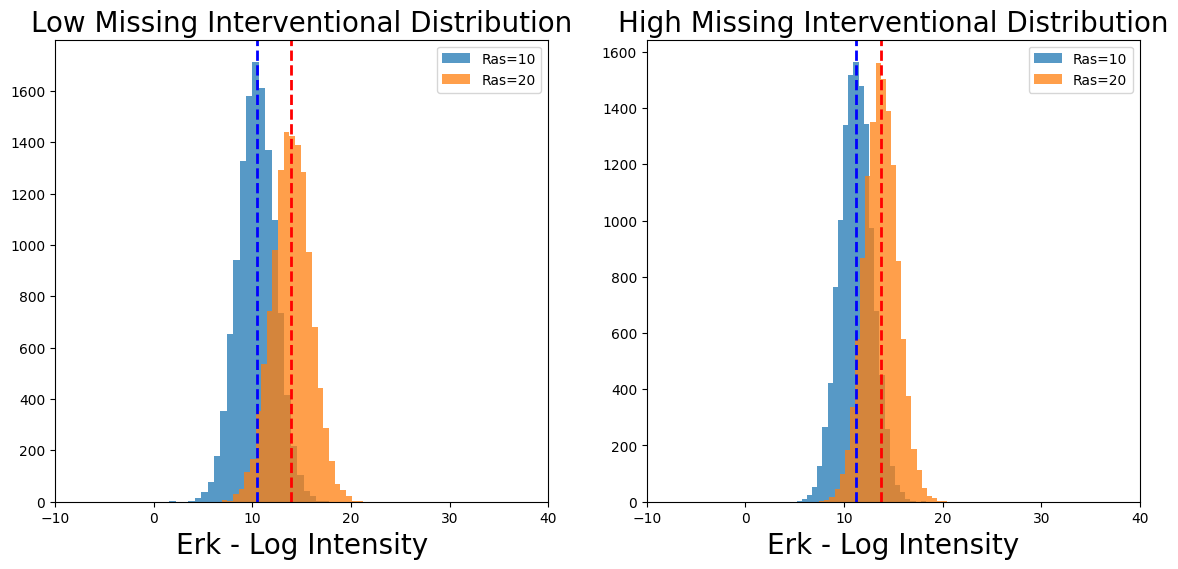

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].hist(low_missing_intervention_results[0], label="Ras=10", alpha=.75, bins=25)
ax[0].hist(low_missing_intervention_results[1], label="Ras=20", alpha=.75, bins=25)
ax[0].axvline(x=low_missing_intervention_results[0].mean(), color="Blue", lw=2, linestyle="--")
ax[0].axvline(x=low_missing_intervention_results[1].mean(), color="Red", lw=2, linestyle="--")
ax[0].legend()

ax[1].hist(high_missing_intervention_results[0], label="Ras=10", alpha=.75, bins=25)
ax[1].hist(high_missing_intervention_results[1], label="Ras=20", alpha=.75, bins=25)
ax[1].axvline(x=high_missing_intervention_results[0].mean(), color="Blue", lw=2, linestyle="--")
ax[1].axvline(x=high_missing_intervention_results[1].mean(), color="Red", lw=2, linestyle="--")
ax[1].legend()

ax[0].set_xlim(-10,40)
ax[1].set_xlim(-10,40)

plt.legend()

ax[0].set_title("Low Missing Interventional Distribution", size=20)
ax[0].set_xlabel("Erk - Log Intensity", size=20)

ax[1].set_title("High Missing Interventional Distribution", size=20)
ax[1].set_xlabel("Erk - Log Intensity", size=20)

# # ax.set_ylabel("Erk", size=24)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

### Figure out why Pyro model is broken

In [7]:
lvm.imputed_data

,protein,intensity,imp_mean,imp_scale
0,Akt,23.969978,NaN,NaN
1,Akt,20.685257,NaN,NaN
2,Akt,18.480347,NaN,NaN
3,Akt,19.260349,NaN,NaN
4,Akt,18.822550,NaN,NaN
...,...,...,...,...
2245,SOS,14.168043,NaN,NaN
2246,SOS,11.151333,NaN,NaN
2247,SOS,14.571370,NaN,NaN
2248,SOS,NaN,16.197166,0.917314


In [10]:
mek_data = high_missing_intervention_results[2].imputed_data.loc[
    low_missing_intervention_results[2].imputed_data["protein"] == "Mek"]
raf_data = high_missing_intervention_results[2].imputed_data.loc[
    low_missing_intervention_results[2].imputed_data["protein"] == "Raf"]

mek_data.loc[:, "full_int"] = np.where(np.isnan(mek_data.loc[:, "intensity"]),
                                       mek_data.loc[:, "imp_mean"], 
                                       mek_data.loc[:, "intensity"])
raf_data.loc[:, "full_int"] = np.where(np.isnan(raf_data.loc[:, "intensity"]),
                                       raf_data.loc[:, "imp_mean"], 
                                       raf_data.loc[:, "intensity"])


low_miss_mek_data = low_missing_intervention_results[2].imputed_data.loc[
    low_missing_intervention_results[2].imputed_data["protein"] == "Mek"]
low_miss_raf_data = low_missing_intervention_results[2].imputed_data.loc[
    low_missing_intervention_results[2].imputed_data["protein"] == "Raf"]

low_miss_mek_data.loc[:, "full_int"] = np.where(
    np.isnan(low_miss_mek_data.loc[:, "intensity"]),
    low_miss_mek_data.loc[:, "imp_mean"], 
    low_miss_mek_data.loc[:, "intensity"])
low_miss_raf_data.loc[:, "full_int"] = np.where(
    np.isnan(low_miss_raf_data.loc[:, "intensity"]),
    low_miss_raf_data.loc[:, "imp_mean"], 
    low_miss_raf_data.loc[:, "intensity"])


(0.0, 10.5)

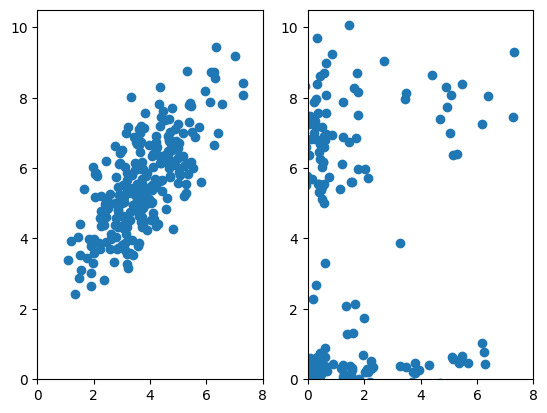

In [11]:
fig, ax = plt.subplots(1, 2)

ax[0].scatter(low_miss_raf_data["full_int"], low_miss_mek_data["full_int"])
ax[1].scatter(raf_data["full_int"], mek_data["full_int"])

ax[0].set_xlim(0,8)
ax[1].set_xlim(0,8)
ax[0].set_ylim(0,10.5)
ax[1].set_ylim(0,10.5)

In [10]:
lvm.parameters

,parameter,mean,scale
0,SOS_intercept,15.666297,0.084860794
1,SOS_scale,0.4074488,0.039749056
2,Ras_intercept,5.42356,0.053143438
3,Ras_SOS_coef,0.50578403,0.0032616346
4,Ras_scale,-0.14775996,0.043372575
5,PI3K_intercept,6.816835,0.07716156
6,PI3K_Ras_coef,1.3955182,0.005627557
7,PI3K_scale,0.20426114,0.04520719
8,Akt_intercept,1.4051143,0.060989495
9,Akt_PI3K_coef,0.7396799,0.0023835269


### Checkout simulated data - Comparison

Add in imputed values

In [51]:
mek_imp = lvm.summary_stats["imp_Mek"]["mean"]
raf_imp = scm.summary_stats["imp_Raf"]["mean"]
mek_std = scm.summary_stats["imp_Mek"]["std"]
raf_std = scm.summary_stats["imp_Raf"]["std"]

## Add in missing data
high_missing_protein_data.loc[:, "imp_Mek"] = high_missing_protein_data.loc[:, "Mek"].isna()
high_missing_protein_data.loc[:, "imp_Raf"] = high_missing_protein_data.loc[:, "Raf"].isna()
high_missing_protein_data.loc[:, "full_Mek"] = high_missing_protein_data.loc[:, "Mek"]
high_missing_protein_data.loc[:, "full_Raf"] = high_missing_protein_data.loc[:, "Raf"]

high_missing_protein_data.loc[:, "Mek_std"] = np.nan
high_missing_protein_data.loc[:, "Raf_std"] = np.nan
high_missing_protein_data.loc[high_missing_protein_data["imp_Mek"], "Mek_std"] = mek_std
high_missing_protein_data.loc[high_missing_protein_data["imp_Raf"], "Raf_std"] = raf_std

high_missing_protein_data.loc[high_missing_protein_data["imp_Mek"], "full_Mek"] = mek_imp
high_missing_protein_data.loc[high_missing_protein_data["imp_Raf"], "full_Raf"] = raf_imp

mek_imp_high = intervention_results["high"][2].summary_stats["imp_Mek"]["mean"]
raf_imp_high = intervention_results["high"][2].summary_stats["imp_Raf"]["mean"]
mek_std_high = intervention_results["high"][2].summary_stats["imp_Mek"]["std"]
raf_std_high = intervention_results["high"][2].summary_stats["imp_Raf"]["std"]

## Add in missing data
high_rep_protein_data.loc[:, "imp_Mek"] = high_rep_protein_data.loc[:, "Mek"].isna()
high_rep_protein_data.loc[:, "imp_Raf"] = high_rep_protein_data.loc[:, "Raf"].isna()
high_rep_protein_data.loc[:, "full_Mek"] = high_rep_protein_data.loc[:, "Mek"]
high_rep_protein_data.loc[:, "full_Raf"] = high_rep_protein_data.loc[:, "Raf"]

high_rep_protein_data.loc[:, "Mek_std"] = np.nan
high_rep_protein_data.loc[:, "Raf_std"] = np.nan
high_rep_protein_data.loc[high_rep_protein_data["imp_Mek"], "Mek_std"] = mek_std_high
high_rep_protein_data.loc[high_rep_protein_data["imp_Raf"], "Raf_std"] = raf_std_high

high_rep_protein_data.loc[high_rep_protein_data["imp_Mek"], "full_Mek"] = mek_imp_high
high_rep_protein_data.loc[high_rep_protein_data["imp_Raf"], "full_Raf"] = raf_imp_high

Calculate regression lines

In [48]:
low_missing_lm = linear_model.LinearRegression()
x = high_rep_protein_data.dropna()[["Raf"]]
y = high_rep_protein_data.dropna()[["Mek"]]
low_missing_lm.fit(x, y)

low_missing_imp_lm = linear_model.LinearRegression()
x = high_rep_protein_data[["full_Raf"]]
y = high_rep_protein_data[["full_Mek"]]
low_missing_imp_lm.fit(x, y)

high_missing_lm = linear_model.LinearRegression()
x = high_missing_protein_data.dropna()[["Raf"]]
y = high_missing_protein_data.dropna()[["Mek"]]
high_missing_lm.fit(x, y)

high_missing_imp_lm = linear_model.LinearRegression()
x = high_missing_protein_data[["full_Raf"]]
y = high_missing_protein_data[["full_Mek"]]
high_missing_imp_lm.fit(x, y)

LinearRegression()

Plot

Text(0, 0.5, 'Mek')

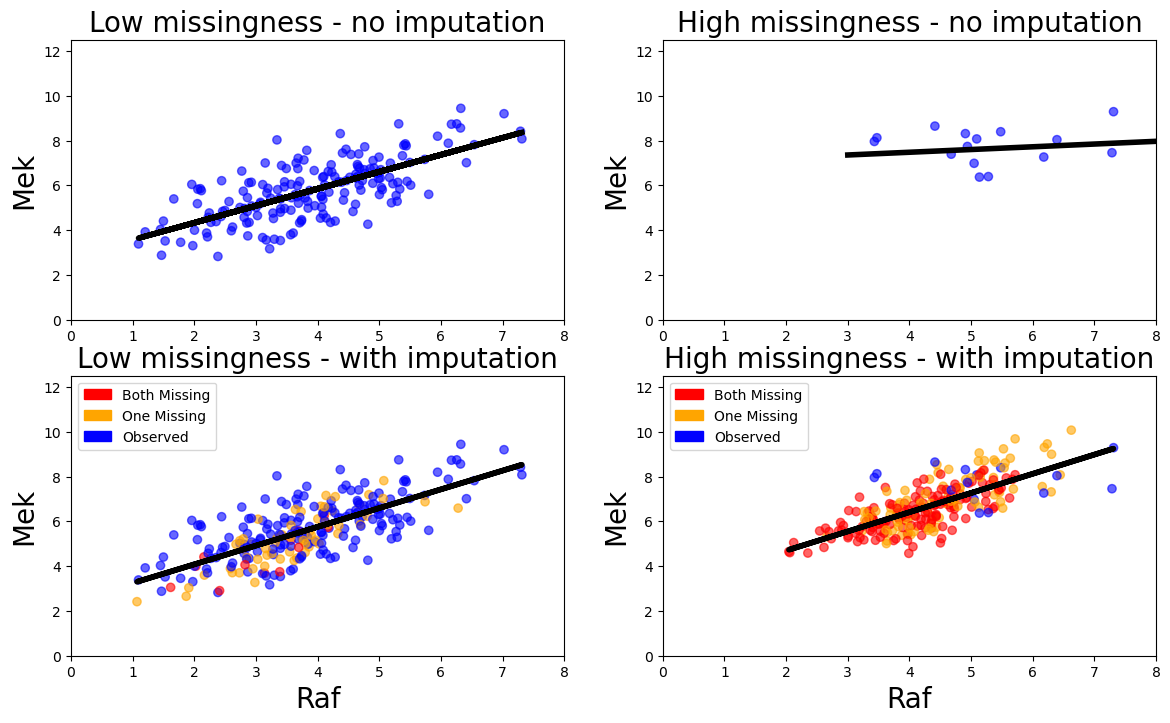

In [49]:
## Plot
fig, ax = plt.subplots(2, 2, figsize=(14,8))

colors1 = np.where((high_rep_protein_data["imp_Mek"] == True) & \
                   (high_rep_protein_data["imp_Raf"] == True), "Red", 
                  np.where((high_rep_protein_data["imp_Raf"] == True) | \
                           (high_rep_protein_data["imp_Mek"] == True), "Orange", "Blue"))

colors2 = np.where((high_missing_protein_data["imp_Mek"] == True) & \
                   (high_missing_protein_data["imp_Raf"] == True), "Red", 
                  np.where((high_missing_protein_data["imp_Raf"] == True) | \
                           (high_missing_protein_data["imp_Mek"] == True), "Orange", "Blue"))

ax[0,0].scatter(high_rep_protein_data["Raf"], high_rep_protein_data["Mek"], c=colors1, alpha=.6)
ax[0,0].plot(high_rep_protein_data["Raf"], 
           low_missing_lm.coef_[0]*high_rep_protein_data["Raf"] + low_missing_lm.intercept_[0], 
           color="black", lw=4)

ax[1,0].scatter(high_rep_protein_data["full_Raf"], high_rep_protein_data["full_Mek"], 
              c=colors1, alpha=.6)
ax[1,0].plot(high_rep_protein_data["full_Raf"], 
           low_missing_imp_lm.coef_[0]*high_rep_protein_data["full_Raf"] + low_missing_imp_lm.intercept_[0], 
           color="black", lw=4)

ax[0,1].scatter(high_missing_protein_data["Raf"], high_missing_protein_data["Mek"], 
              c=colors2, alpha=.6)
ax[0,1].plot(np.arange(3,9), 
           high_missing_lm.coef_[0]*np.arange(3,9) + high_missing_lm.intercept_[0], 
           color="black", lw=4)

ax[1,1].scatter(high_missing_protein_data["full_Raf"], high_missing_protein_data["full_Mek"], 
              c=colors2, alpha=.6)
ax[1,1].plot(high_missing_protein_data["full_Raf"], 
           high_missing_imp_lm.coef_[0]*high_missing_protein_data["full_Raf"] + high_missing_imp_lm.intercept_[0], 
           color="black", lw=4)

red_patch = mpatches.Patch(color='red', label='Both Missing')
orange_patch = mpatches.Patch(color='orange', label='One Missing')
blue_patch = mpatches.Patch(color='blue', label='Observed')

ax[1,1].legend(handles=[red_patch, orange_patch, blue_patch])
ax[1,0].legend(handles=[red_patch, orange_patch, blue_patch])

ax[0,0].set_xlim(0,8)
ax[1,1].set_xlim(0,8)
ax[0,1].set_xlim(0,8)
ax[1,0].set_xlim(0,8)
ax[0,0].set_ylim(0,12.5)
ax[1,1].set_ylim(0,12.5)
ax[0,1].set_ylim(0,12.5)
ax[1,0].set_ylim(0,12.5)

ax[0,0].set_title("Low missingness - no imputation", size=20)
ax[1,1].set_title("High missingness - with imputation", size=20)
ax[1,0].set_title("Low missingness - with imputation", size=20)
ax[0,1].set_title("High missingness - no imputation", size=20)

# ax[0,0].set_xlabel("Raf")
# ax[0,1].set_xlabel("Raf")
ax[1,1].set_xlabel("Raf", size=20)
ax[1,0].set_xlabel("Raf", size=20)

ax[0,0].set_ylabel("Mek", size=20)
ax[0,1].set_ylabel("Mek", size=20)
ax[1,1].set_ylabel("Mek", size=20)
ax[1,0].set_ylabel("Mek", size=20)

### Checkout simulated data - only high missing

In [12]:
mek_imp = scm.summary_stats["imp_Mek"]["mean"]
raf_imp = scm.summary_stats["imp_Raf"]["mean"]
mek_std = scm.summary_stats["imp_Mek"]["std"]
raf_std = scm.summary_stats["imp_Raf"]["std"]

## Add in missing data
high_missing_protein_data.loc[:, "imp_Mek"] = high_missing_protein_data.loc[:, "Mek"].isna()
high_missing_protein_data.loc[:, "imp_Raf"] = high_missing_protein_data.loc[:, "Raf"].isna()
high_missing_protein_data.loc[:, "full_Mek"] = high_missing_protein_data.loc[:, "Mek"]
high_missing_protein_data.loc[:, "full_Raf"] = high_missing_protein_data.loc[:, "Raf"]

high_missing_protein_data.loc[high_missing_protein_data["imp_Mek"], "full_Mek"] = mek_imp
high_missing_protein_data.loc[high_missing_protein_data["imp_Raf"], "full_Raf"] = raf_imp

In [13]:
high_missing_protein_data

,originalRUN,Akt,EGF,Erk,IGF,Mek,PI3K,Raf,Ras,SOS,imp_Mek,imp_Raf,full_Mek,full_Raf
0,0_Obs,23.969979,23.609577,11.254368,20.276095,NaN,31.478477,NaN,16.526868,20.769053,True,True,6.636600,5.009215
1,1_Obs,20.685256,19.517891,10.179550,16.983482,NaN,25.695139,NaN,11.948731,15.923720,True,True,5.577643,2.851124
2,10_Obs,18.480347,18.749568,11.830878,15.144268,NaN,22.944948,NaN,12.571201,15.287207,True,True,6.764249,4.502989
3,100_Obs,19.260349,23.966830,10.909404,16.419784,6.385109,25.382946,NaN,11.434613,NaN,False,True,6.385109,3.317856
4,101_Obs,18.822550,14.274101,9.479468,NaN,NaN,20.049100,NaN,10.044909,11.676932,True,True,5.050595,2.122465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,221_Obs,NaN,17.279474,NaN,17.092482,5.603125,24.206758,NaN,13.431031,14.168043,False,True,5.603125,4.305103
246,248_Obs,NaN,15.877285,11.002502,NaN,NaN,21.091752,NaN,9.789191,11.151333,True,True,5.947886,2.883149
247,59_Obs,NaN,17.229154,13.237483,NaN,NaN,24.058757,NaN,12.687029,14.571370,True,True,7.426697,4.519221
248,69_Obs,NaN,18.473332,NaN,18.390300,NaN,26.435185,NaN,13.877995,NaN,True,True,6.717400,4.405680


In [14]:
high_missing_lm = linear_model.LinearRegression()
x = high_missing_protein_data.dropna()[["Raf"]]
y = high_missing_protein_data.dropna()[["Mek"]]
high_missing_lm.fit(x, y)

high_missing_imp_lm = linear_model.LinearRegression()
x = high_missing_protein_data[["full_Raf"]]
y = high_missing_protein_data[["full_Mek"]]
high_missing_imp_lm.fit(x, y)

LinearRegression()

In [15]:
high_missing_imp_lm.coef_

array([[0.85737596]])

Text(0, 0.5, 'Mek')

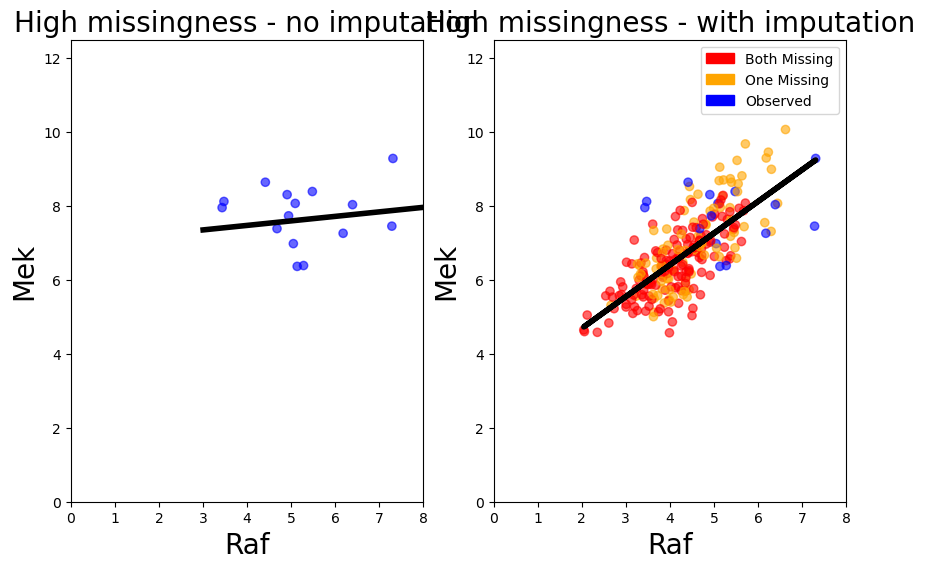

In [16]:
## Plot
fig, ax = plt.subplots(1, 2, figsize=(10,6))


colors2 = np.where((high_missing_protein_data["imp_Mek"] == True) & \
                   (high_missing_protein_data["imp_Raf"] == True), "Red", 
                  np.where((high_missing_protein_data["imp_Raf"] == True) | \
                           (high_missing_protein_data["imp_Mek"] == True), "Orange", "Blue"))


ax[0].scatter(high_missing_protein_data["Raf"], high_missing_protein_data["Mek"], 
              c=colors2, alpha=.6)
ax[0].plot(np.arange(3,9), 
           high_missing_lm.coef_[0]*np.arange(3,9) + high_missing_lm.intercept_[0], 
           color="black", lw=4)

ax[1].scatter(high_missing_protein_data["full_Raf"], high_missing_protein_data["full_Mek"], 
              c=colors2, alpha=.6)
ax[1].plot(high_missing_protein_data["full_Raf"], 
           high_missing_imp_lm.coef_[0]*high_missing_protein_data["full_Raf"] + high_missing_imp_lm.intercept_[0], 
           color="black", lw=4)

red_patch = mpatches.Patch(color='red', label='Both Missing')
orange_patch = mpatches.Patch(color='orange', label='One Missing')
blue_patch = mpatches.Patch(color='blue', label='Observed')

ax[1].legend(handles=[red_patch, orange_patch, blue_patch])

ax[1].set_xlim(0,8)
ax[0].set_xlim(0,8)
ax[1].set_ylim(0,12.5)
ax[0].set_ylim(0,12.5)

ax[1].set_title("High missingness - with imputation", size=20)
ax[0].set_title("High missingness - no imputation", size=20)

# ax[0,0].set_xlabel("Raf")
# ax[0,1].set_xlabel("Raf")
ax[1].set_xlabel("Raf", size=20)
ax[0].set_xlabel("Raf", size=20)

ax[0].set_ylabel("Mek", size=20)
ax[1].set_ylabel("Mek", size=20)

In [17]:
high_missing_protein_data.loc[:, "Mek_std"] = np.nan
high_missing_protein_data.loc[:, "Raf_std"] = np.nan
high_missing_protein_data.loc[high_missing_protein_data["imp_Mek"], "Mek_std"] = mek_std
high_missing_protein_data.loc[high_missing_protein_data["imp_Raf"], "Raf_std"] = raf_std

In [18]:
high_missing_protein_data

,originalRUN,Akt,EGF,Erk,IGF,Mek,PI3K,Raf,Ras,SOS,imp_Mek,imp_Raf,full_Mek,full_Raf,Mek_std,Raf_std
0,0_Obs,23.969979,23.609577,11.254368,20.276095,NaN,31.478477,NaN,16.526868,20.769053,True,True,6.636600,5.009215,0.736649,0.767241
1,1_Obs,20.685256,19.517891,10.179550,16.983482,NaN,25.695139,NaN,11.948731,15.923720,True,True,5.577643,2.851124,0.739497,0.786743
2,10_Obs,18.480347,18.749568,11.830878,15.144268,NaN,22.944948,NaN,12.571201,15.287207,True,True,6.764249,4.502989,0.711214,0.743253
3,100_Obs,19.260349,23.966830,10.909404,16.419784,6.385109,25.382946,NaN,11.434613,NaN,False,True,6.385109,3.317856,NaN,0.741746
4,101_Obs,18.822550,14.274101,9.479468,NaN,NaN,20.049100,NaN,10.044909,11.676932,True,True,5.050595,2.122465,0.706354,0.833650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,221_Obs,NaN,17.279474,NaN,17.092482,5.603125,24.206758,NaN,13.431031,14.168043,False,True,5.603125,4.305103,NaN,0.817386
246,248_Obs,NaN,15.877285,11.002502,NaN,NaN,21.091752,NaN,9.789191,11.151333,True,True,5.947886,2.883149,0.741620,0.912781
247,59_Obs,NaN,17.229154,13.237483,NaN,NaN,24.058757,NaN,12.687029,14.571370,True,True,7.426697,4.519221,0.719706,0.860905
248,69_Obs,NaN,18.473332,NaN,18.390300,NaN,26.435185,NaN,13.877995,NaN,True,True,6.717400,4.405680,1.165063,0.929886


(0.6, 1.3)

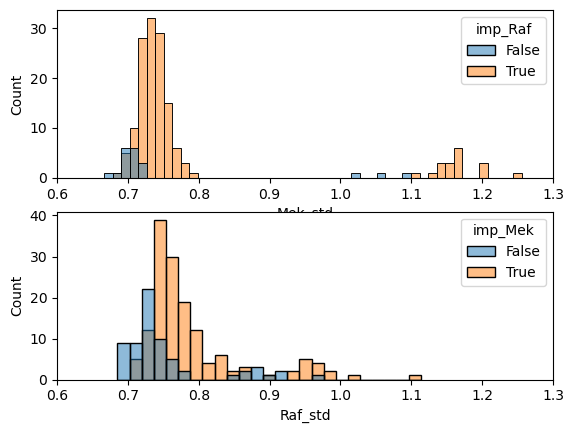

In [36]:
fig, ax = plt.subplots(2,1)
sns.histplot(data=high_missing_protein_data, x="Mek_std", hue="imp_Raf", ax=ax[0])
sns.histplot(data=high_missing_protein_data, x="Raf_std", hue="imp_Mek", ax=ax[1])
ax[0].set_xlim(.6,1.3)
ax[1].set_xlim(.6,1.3)

In [33]:
high_missing_protein_data.head()

,originalRUN,Akt,EGF,Erk,IGF,Mek,PI3K,Raf,Ras,SOS,...,imp_Raf,full_Mek,full_Raf,Mek_std,Raf_std,True_Raf,True_Mek,Raf_error,Mek_error,missing_count
0,0_Obs,23.969979,23.609577,11.254368,20.276095,NaN,31.478477,NaN,16.526868,20.769053,...,True,6.636600,5.009215,0.736649,0.767241,5.338703,7.090611,0.329488,0.454011,NaN
1,1_Obs,20.685256,19.517891,10.179550,16.983482,NaN,25.695139,NaN,11.948731,15.923720,...,True,5.577643,2.851124,0.739497,0.786743,2.631990,6.393248,0.219134,0.815605,NaN
2,10_Obs,18.480347,18.749568,11.830878,15.144268,NaN,22.944948,NaN,12.571201,15.287207,...,True,6.764249,4.502989,0.711214,0.743253,5.091677,7.752938,0.588688,0.988688,NaN
3,100_Obs,19.260349,23.966830,10.909404,16.419784,6.385109,25.382946,NaN,11.434613,NaN,...,True,6.385109,3.317856,NaN,0.741746,4.670147,5.111105,1.352291,1.274004,NaN
4,101_Obs,18.822550,14.274101,9.479468,NaN,NaN,20.049100,NaN,10.044909,11.676932,...,True,5.050595,2.122465,0.706354,0.833650,3.639944,6.598965,1.517480,1.548370,NaN


<Axes: xlabel='Raf_error', ylabel='Count'>

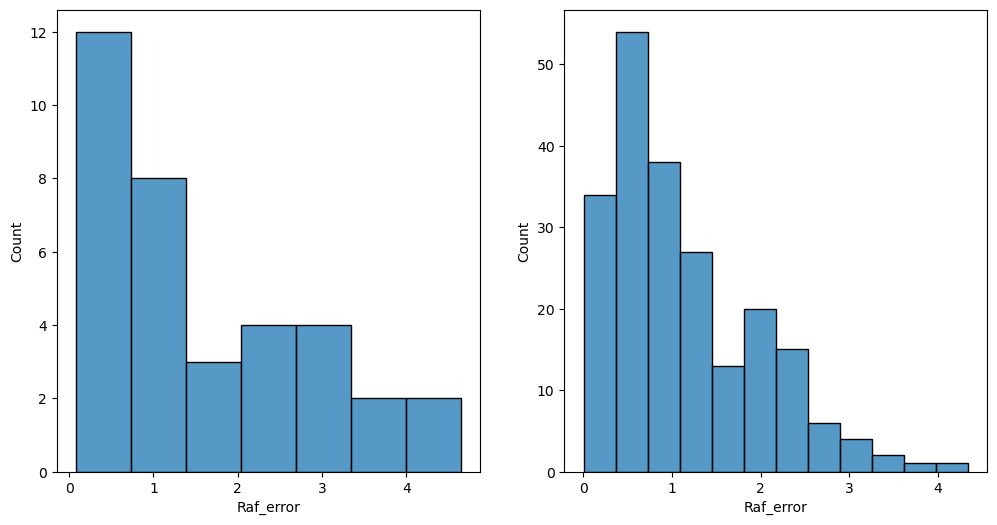

In [49]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.histplot(data=high_missing_protein_data[-high_missing_protein_data["imp_Raf"]], x="Raf_error", ax=ax[0])
sns.histplot(data=high_missing_protein_data[high_missing_protein_data["imp_Raf"]], x="Raf_error", ax=ax[1])

<Axes: xlabel='Mek_error', ylabel='Count'>

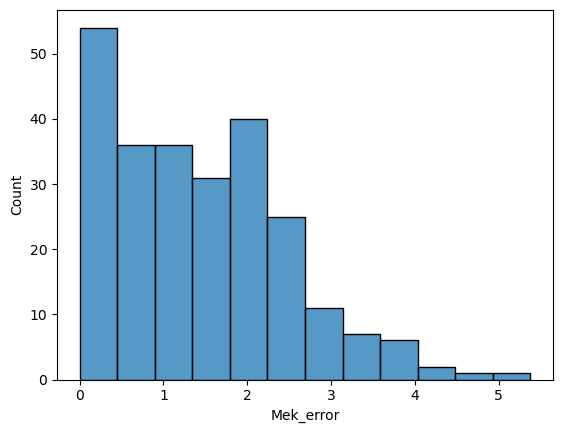

In [46]:
fig, ax = plt.subplots()
sns.histplot(data=high_missing_protein_data, x="Mek_error")

In [20]:
high_missing_protein_data.loc[:, "True_Raf"] = high_missing_data["Protein_data"]["Raf"]
high_missing_protein_data.loc[:, "True_Mek"] = high_missing_data["Protein_data"]["Mek"]

(0.0, 4.5)

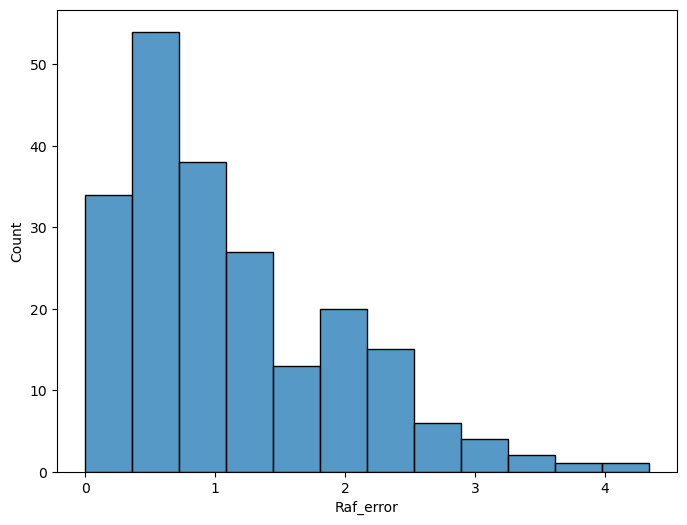

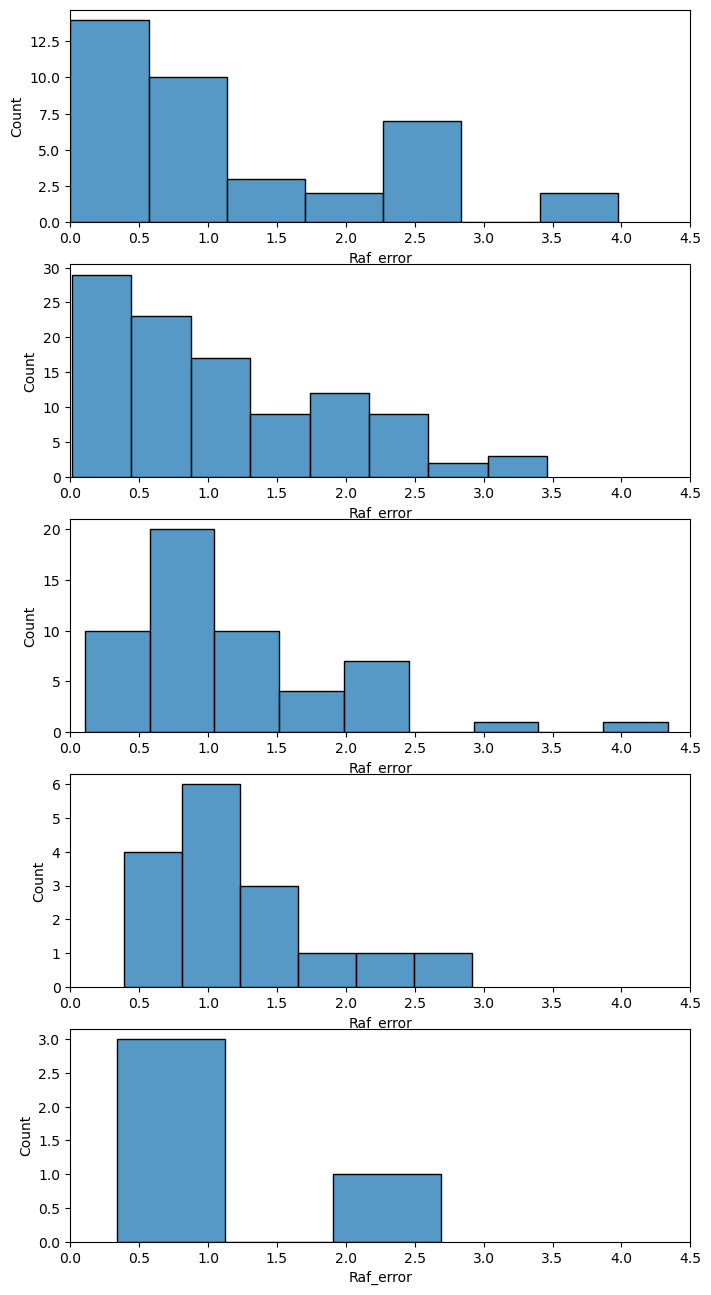

In [44]:
high_missing_protein_data.loc[:, "Raf_error"] = abs(high_missing_protein_data.loc[:, "True_Raf"] - high_missing_protein_data.loc[:, "full_Raf"])

high_missing_protein_data.loc[:, "missing_count"] = high_missing_protein_data.loc[:, ["Akt", "EGF", "Erk", "IGF", 
                                                                                     "Mek", "PI3K", "Raf", "Ras", "SOS"]].isna().sum(axis=1).values

fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=high_missing_protein_data[high_missing_protein_data["imp_Raf"]], x="Raf_error", ax=ax)

fig, ax = plt.subplots(5,1, figsize=(8,16))
sns.histplot(data=high_missing_protein_data[(high_missing_protein_data["imp_Raf"]) & 
                                           (high_missing_protein_data["missing_count"] == 1)], x="Raf_error", ax=ax[0])
sns.histplot(data=high_missing_protein_data[(high_missing_protein_data["imp_Raf"]) & 
                                           (high_missing_protein_data["missing_count"] == 2)], x="Raf_error", ax=ax[1])
sns.histplot(data=high_missing_protein_data[(high_missing_protein_data["imp_Raf"]) & 
                                           (high_missing_protein_data["missing_count"] == 3)], x="Raf_error", ax=ax[2])
sns.histplot(data=high_missing_protein_data[(high_missing_protein_data["imp_Raf"]) & 
                                           (high_missing_protein_data["missing_count"] == 4)], x="Raf_error", ax=ax[3])
sns.histplot(data=high_missing_protein_data[(high_missing_protein_data["imp_Raf"]) & 
                                           (high_missing_protein_data["missing_count"] == 5)], x="Raf_error", ax=ax[4])
ax[0].set_xlim(0,4.5)
ax[1].set_xlim(0,4.5)
ax[2].set_xlim(0,4.5)
ax[3].set_xlim(0,4.5)
ax[4].set_xlim(0,4.5)

<Axes: xlabel='Mek_error', ylabel='Count'>

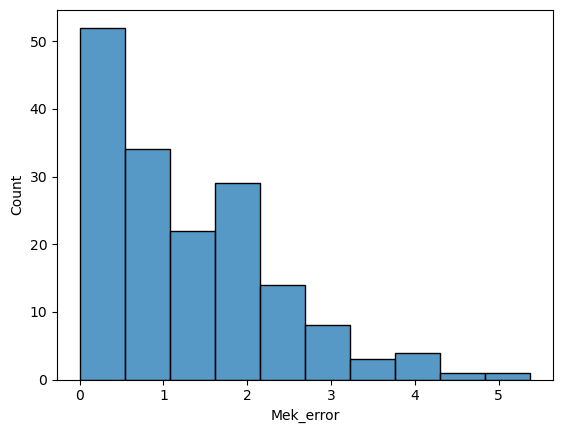

In [25]:
high_missing_protein_data.loc[:, "Mek_error"] = abs(high_missing_protein_data.loc[:, "True_Mek"] - high_missing_protein_data.loc[:, "full_Mek"])

fig, ax = plt.subplots()
sns.histplot(data=high_missing_protein_data[high_missing_protein_data["imp_Mek"]], x="Mek_error")